# Fase 3: Análisis y tratamiento de datos perdidos

El objetivo de esta etapa es comprobar la existencia de datos perdidos, analizar su distribución entre las variables y tipología y llevar a cabo los tratamientos pertinentes.

Se han llevado a cabo las siguientes tareas:
- Análisis de datos perdidos
    - Conteo y distribución
    - Análisis del tipo de dato perdido por variable
- Imputación de datos perdidos
    - Preparación de los datos
    - Imputación
    - Análisis de los resultados
- Eliminación de la variable notRepairedDamage
- Eliminación de datos perdidos
    - Análisis de los resultados
- Exportación del dataset

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

import ancillary_funcs as aux

import missingno as msngo
from scipy import stats

import warnings
warnings.simplefilter('ignore')

In [2]:
# Definición del tipo, tamaño y resolución de los gráficos
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10,6) #12,8
plt.rcParams["figure.dpi"] = 70
plt.rcParams['axes.titlesize'] = 20

## El dataset después de la limpieza de datos
El dataset resultante de la limpieza de datos tiene unas dimensiones de 248815 filas y 10 columnas.

- `price`: Precio del coche. Es el vector objetivo. (numérica)
- `vehicleType`: tipo de vehículo (categórica: limousine/sedán, kleinwagen/coche pequeño, kombi/familiar, bus/monovolumenes y furgones, cabrio/convertible, coupe, suv, andere/otro)
- `yearOfRegistration`: año en que se registró el automóvil. (numérica)
- `gearbox`: Tipo de caja de cambios (categórica: manuell/manual o automatik/automática)
- `powerPS`: Potencia del coche en PS (numérica)
- `kilometer`: Kilómetros que ha recorrido el coche (numérica)
- `fuelType`: Tipo de combustible (categórica: benzin/gasolina, diesel/diésel, gas, híbrido_electrico, andere/otro)
- `brand`: Marca del coche (categórica)
- `notRepairedDamage`: si el automóvil tiene o no algún daño que no haya sido reparado (categórica: nein/no o ja/si)
- `postalZone`: Zona postal del coche (categórica)

In [3]:
df_original = pd.read_csv('df_stage_2.csv')

In [4]:
df_original.shape

(249215, 10)

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249215 entries, 0 to 249214
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               249215 non-null  int64 
 1   vehicleType         245372 non-null  object
 2   yearOfRegistration  249215 non-null  int64 
 3   gearbox             245252 non-null  object
 4   powerPS             249215 non-null  int64 
 5   kilometer           249215 non-null  int64 
 6   fuelType            238651 non-null  object
 7   brand               249215 non-null  object
 8   notRepairedDamage   216111 non-null  object
 9   postalZone          249215 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 19.0+ MB


In [6]:
df = df_original.copy()

In [7]:
# Transformamos el tipo de dato para la variable 'postalZone'
df['postalZone'] = df['postalZone'].astype('object')

## Análisis de los datos perdidos
- Antes de explorar la cantidad y porcentaje de valores perdidos para cada variable debemos hacer las transformaciones necesarias para que los datos perdidos sean considerados como tal. Nuestro dataset contiene numerosos registros con la categoría 'andere' (otro) que, en definitiva, suponen valores perdidos
- Después haremos un conteo del número y porcentaje de valores perdidos para cada variable
- Trataremos de averiguar el motivo y tipo de dato perdido para cada variable
    - Datos perdidos al azar (MAR): Los datos faltantes están relacionados con otras variables observadas, pero no directamente con el valor faltante.
    - Datos perdidos completamente al azar (MCAR): Los datos faltantes no están relacionados con ninguna otra variable observada o no observada.
    - Datos perdidos no al azar (MNAR): Los datos faltantes están relacionados directamente con el valor que falta y no pueden ser explicados por variables observadas.

### Conteo y distribución de los datos perdidos

In [8]:
df.replace('andere', np.nan, inplace=True)

In [9]:
# Cantidad total de datos perdidos
df.isna().sum().sum()

53364

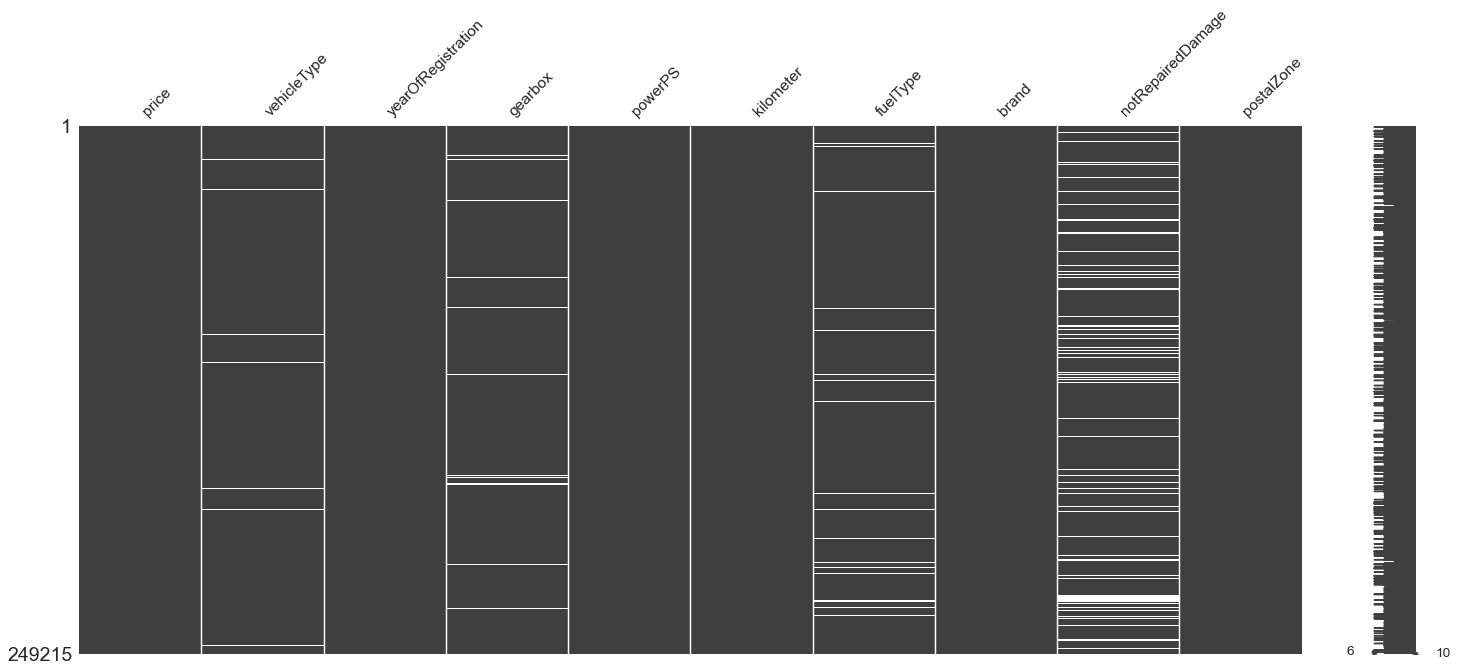

In [10]:
# Visualización de los datos nulos por variable
msngo.matrix(df);

In [11]:
# Cantidad y porcentaje de datos nulos por variable
aux.datos_nulos_analisis(df)

,variable,cantidades,porcentajes
8,notRepairedDamage,33104.0,0.132833
6,fuelType,10602.0,0.042542
1,vehicleType,5695.0,0.022852
3,gearbox,3963.0,0.015902
0,price,0.0,0.000000
2,yearOfRegistration,0.0,0.000000
4,powerPS,0.0,0.000000
5,kilometer,0.0,0.000000
7,brand,0.0,0.000000
9,postalZone,0.0,0.000000


- `notRepairedDamage` tiene un 14% de datos nulos
- `fuelType`, `model` y `vehicleType` están entre el 4 y 5%
- `gearbox` tiene 1.7% de datos nulos

### Análisis del tipo de datos perdidos
- vamos a graficar la distribución Y frecuencia de las variables con datos perdidos con el objetivo de determinar si los datos faltantes dependen de ciertas categorías, del valor de otras variables, de sí mismos o si son completamente aleatorios.

### Variable 'notRepairedDamage'

In [12]:
# Separamos en un dataframe todas las observaciones que tienen 'notRepairedDamage' faltante
df_nulos = df[df.isna().any(1)]
df_nulos['notRepairedDamage'].fillna('nulo', inplace=True)
df_nulos = df_nulos[df_nulos['notRepairedDamage']=='nulo']
df_nulos['postalZone'] = df_nulos['postalZone'].astype('object')
df_nulos.shape

(33104, 10)

In [13]:
# Almacenamos a las variables discretas en la variable categorical_data
categorical_data = df[['vehicleType', 
                       'gearbox', 
                       'fuelType', 
                       'brand',
                       'postalZone',
                       #'notRepairedDamage'
                      ]]


In [14]:
# Almacenamos a las variables continuas en la variable numerical_data
numerical_data= ['price', 'yearOfRegistration', 'powerPS', 'kilometer']

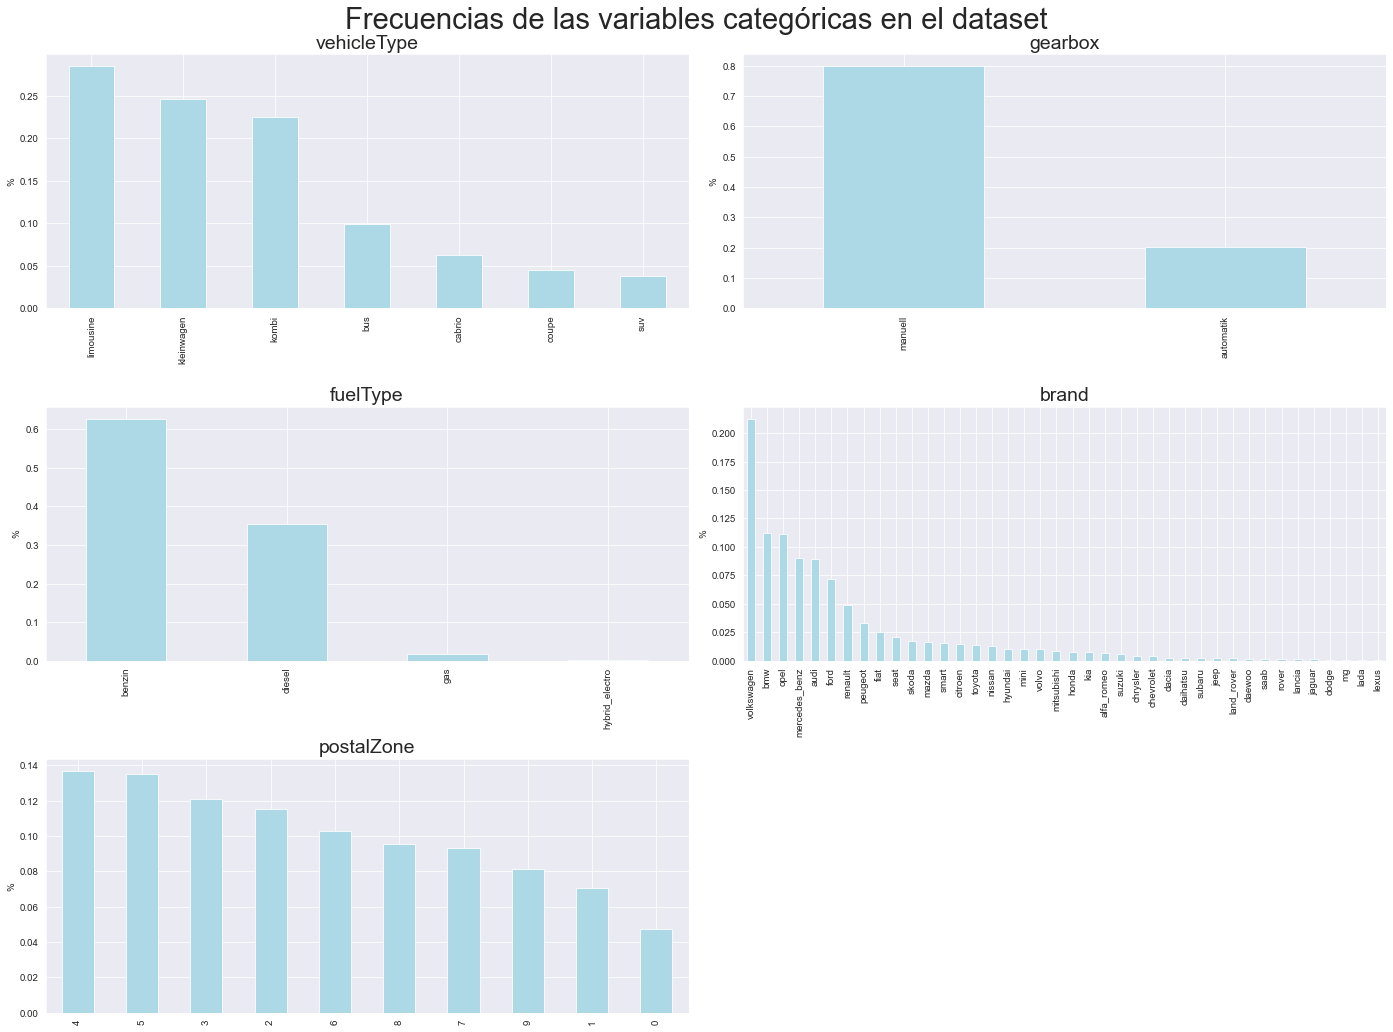

In [15]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

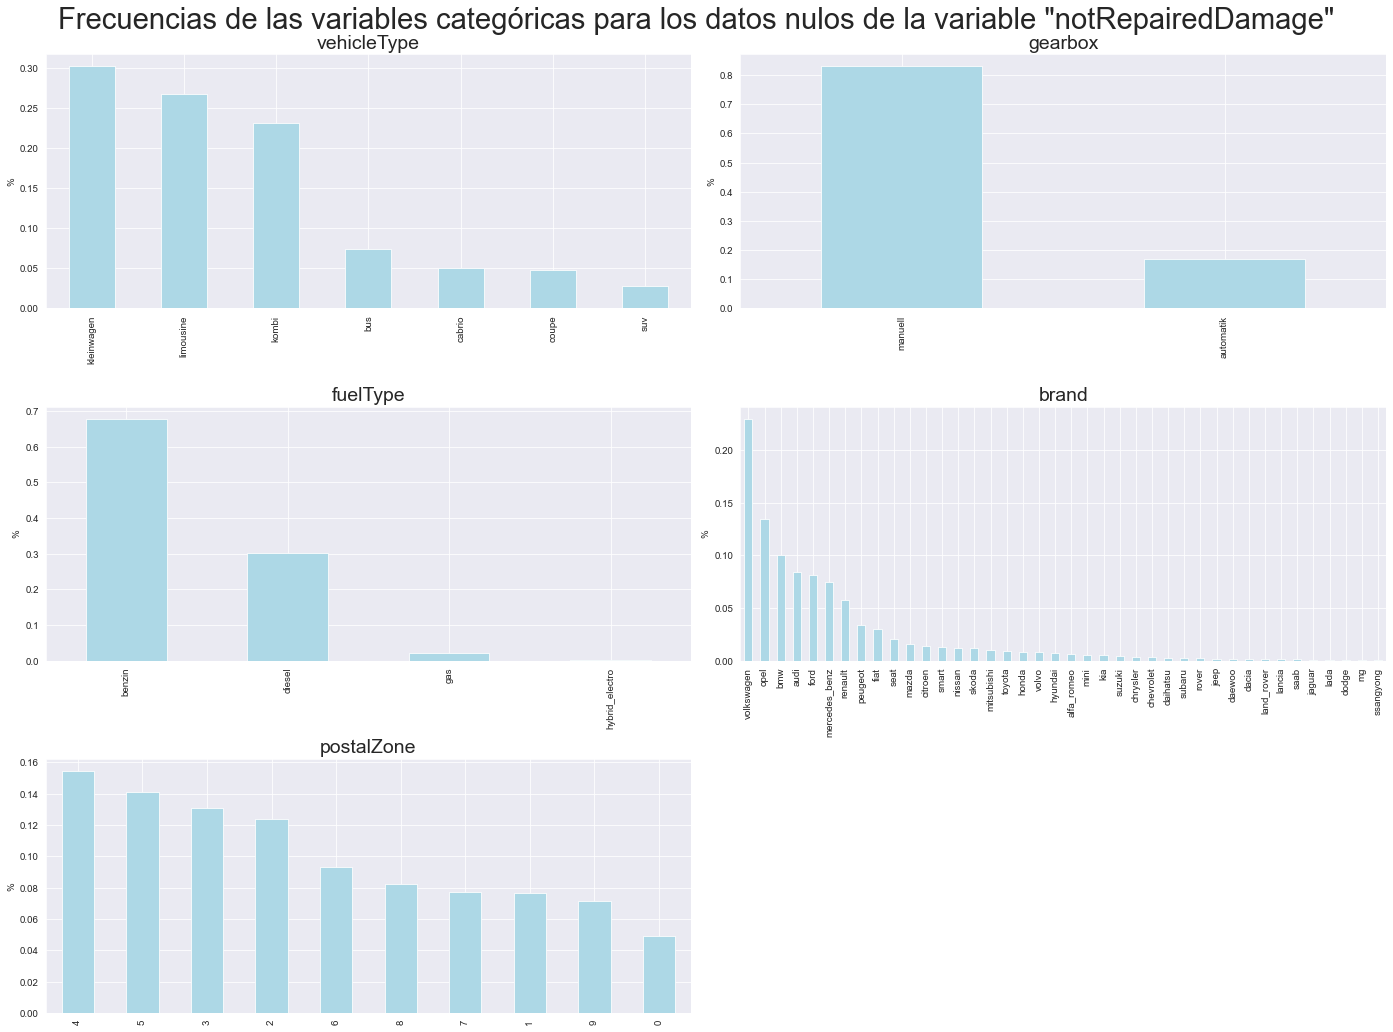

In [16]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df_nulos[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas para los datos nulos de la variable "notRepairedDamage"', fontsize=30)
plt.tight_layout()
plt.show()

In [17]:
print('Datos estadísticos para los registros con valores perdidos en la variable "notRepairedDamage"')
df_nulos.describe()

Datos estadísticos para los registros con valores perdidos en la variable "notRepairedDamage"


,price,yearOfRegistration,powerPS,kilometer
count,33104.000000,33104.000000,33104.000000,33104.000000
mean,3283.446774,2001.684087,111.312832,139581.168439
std,3892.009762,4.281941,45.334027,23210.778359
min,55.000000,1995.000000,23.000000,50000.000000
25%,850.000000,1998.000000,75.000000,150000.000000
50%,1890.000000,2001.000000,105.000000,150000.000000
75%,4100.000000,2005.000000,140.000000,150000.000000
max,34900.000000,2015.000000,250.000000,150000.000000


In [18]:
print('Datos estadísticos en el dataset sin modificaciones')
df.copy().describe().drop(columns='postalZone')

Datos estadísticos en el dataset sin modificaciones


,price,yearOfRegistration,powerPS,kilometer
count,249215.000000,249215.000000,249215.000000,249215.000000
mean,5084.224922,2003.435102,119.920587,132718.957527
std,5233.027125,4.628896,46.737053,29262.723940
min,55.000000,1995.000000,22.000000,50000.000000
25%,1430.000000,2000.000000,80.000000,125000.000000
50%,3200.000000,2003.000000,116.000000,150000.000000
75%,6950.000000,2007.000000,150.000000,150000.000000
max,34999.000000,2015.000000,251.000000,150000.000000


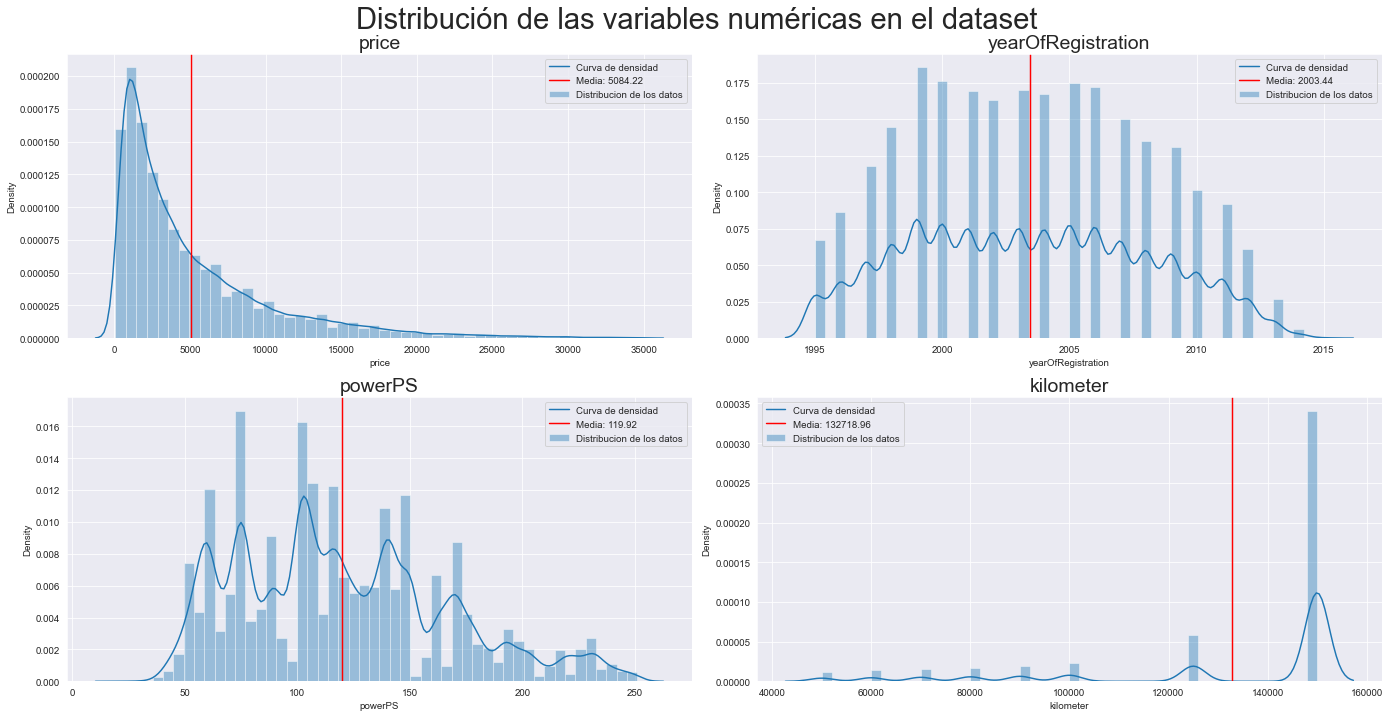

In [19]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna numérica y devolverá un histograma
for i in numerical_data:
    plt.subplot(a, b, c)
    plt.title(i)
    sns.distplot(df[i]).axvline(np.mean(df[i]), color='red')
    plt.legend(labels=['Curva de densidad',f'Media: {round(df[i].mean(),2)}', 'Distribucion de los datos'])
    c = c + 1

plt.suptitle('Distribución de las variables numéricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

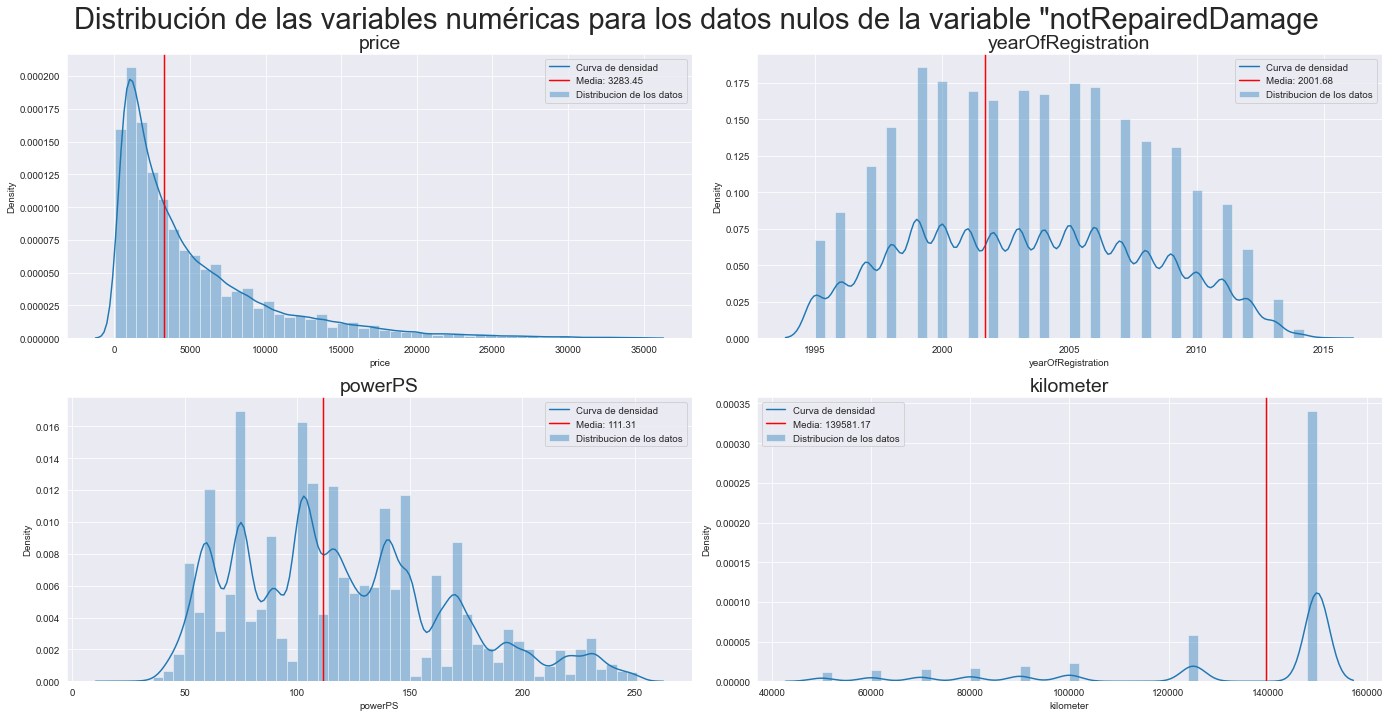

In [20]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna numérica y devolverá un histograma
for i in numerical_data:
    plt.subplot(a, b, c)
    plt.title(i)
    sns.distplot(df[i]).axvline(np.mean(df_nulos[i]), color='red')
    plt.legend(labels=['Curva de densidad',f'Media: {round(df_nulos[i].mean(),2)}', 'Distribucion de los datos'])
    c = c + 1

plt.suptitle('Distribución de las variables numéricas para los datos nulos de la variable "notRepairedDamage', fontsize=30)
plt.tight_layout()
plt.show()

**Conclusiones**
- Se observa una cierta tendencia en los datos nulos de la variable 'notRepairedDamage' hacia autos más baratos, con más kilómetros, menos caballos y donde predominan los compactos (menor valor promedio que los sedán). Sin embargo, estas diferencias con la data completa no suponen un cambio en las distribuciones ni alteraciones fundamentales.
- No se observa que la pérdida de datos esté asociada exclusivamente a alguna categoría.
- La diferencia de la media del precio entre el dataset original y el dataset con los valores perdidos de la variable estudiada eliminados es de unos 370 euros. Pensamos que se trata de una variación importante tratándose de coches de segunda mano

### Variable fuelType

In [21]:
# Separamos en un dataframe todas las observaciones que tienen 'notRepairedDamage' faltante
df_nulos = df[df.isna().any(1)]
df_nulos['fuelType'].fillna('nulo', inplace=True)
df_nulos = df_nulos[df_nulos['fuelType']=='nulo']
df_nulos['fuelType'] = df_nulos['fuelType'].astype('object')
df_nulos.shape

(10602, 10)

In [22]:
# Almacenamos a las variables discretas en la variable categorical_data
categorical_data = df[['vehicleType', 
                       'gearbox', 
                       #'fuelType', 
                       'brand',
                       'postalZone',
                       'notRepairedDamage'
                      ]]


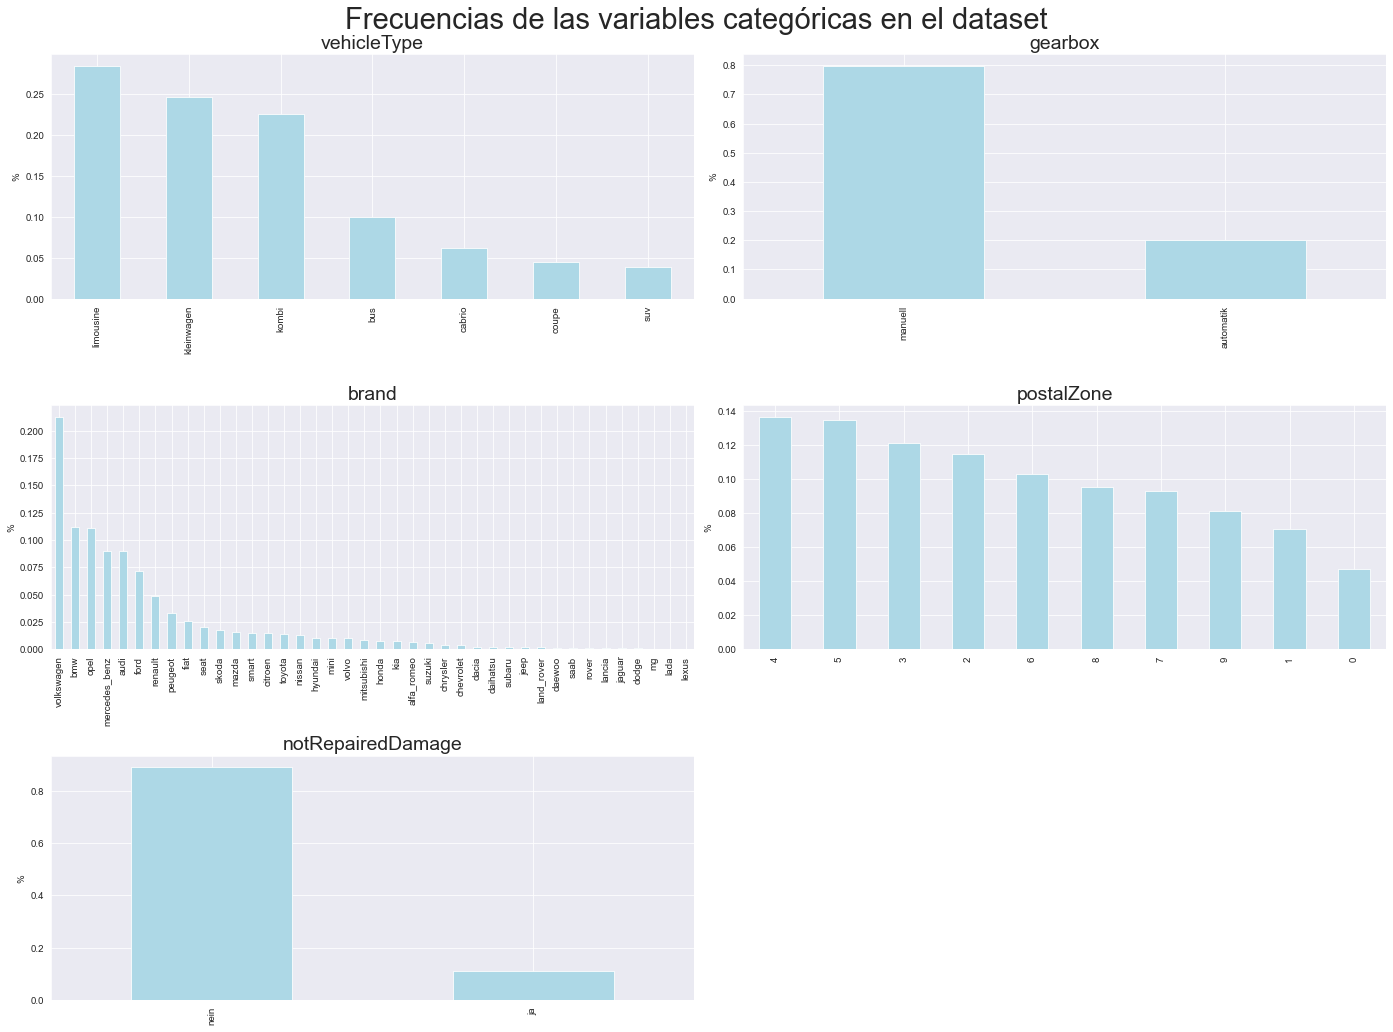

In [23]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

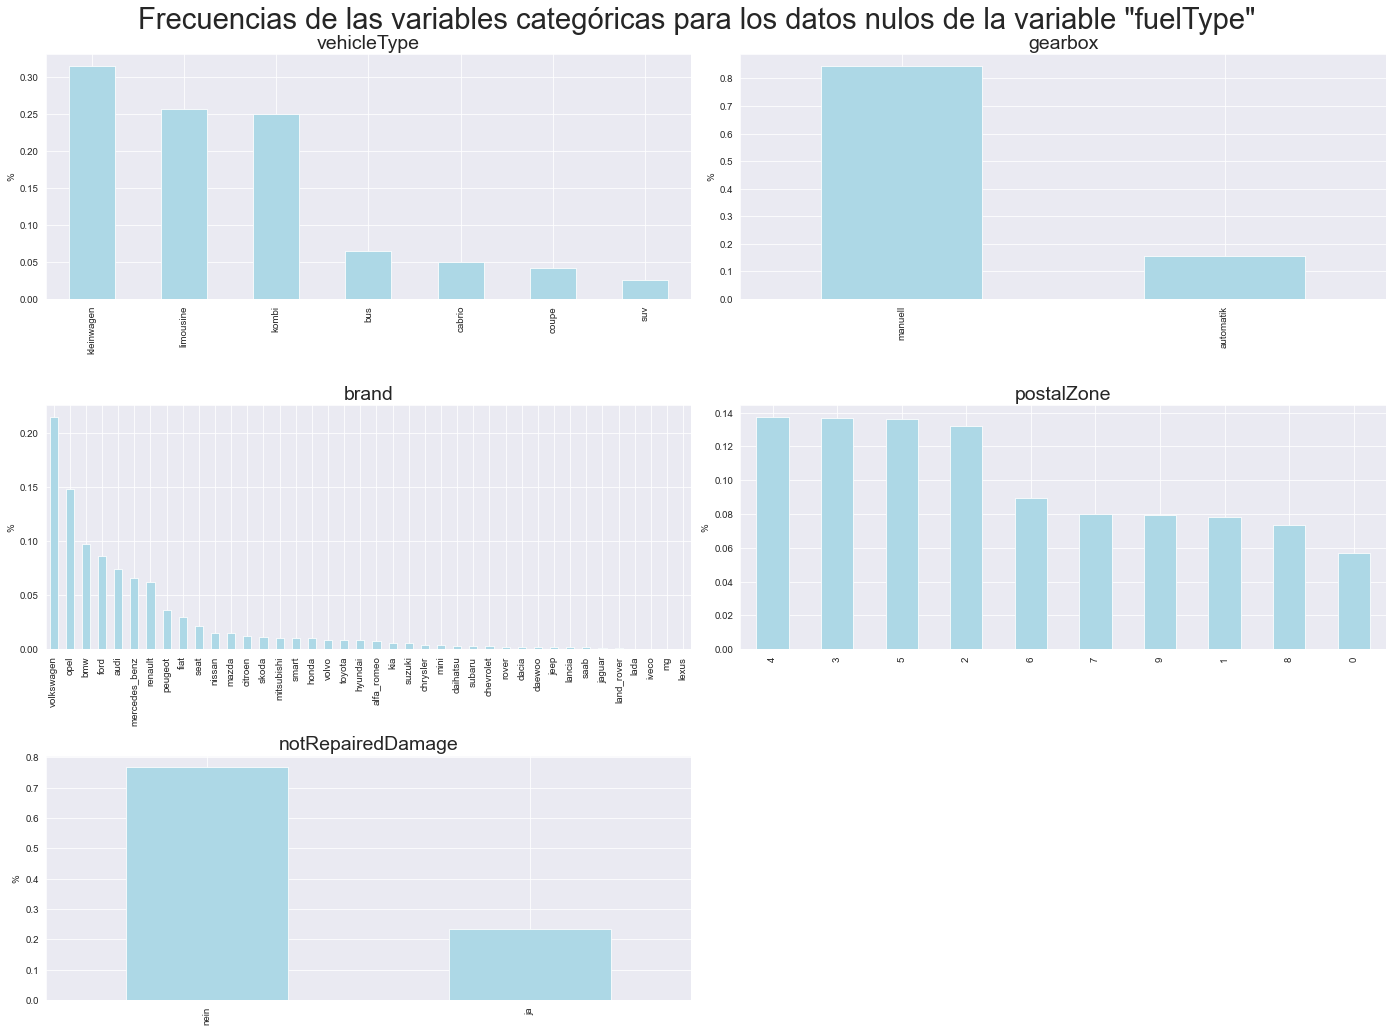

In [24]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df_nulos[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas para los datos nulos de la variable "fuelType"', fontsize=30)
plt.tight_layout()
plt.show()

In [25]:
print('Datos estadísticos para los registros con valores perdidos en la variable "fuelType"')
df_nulos.describe()

Datos estadísticos para los registros con valores perdidos en la variable "fuelType"


,price,yearOfRegistration,powerPS,kilometer,postalZone
count,10602.000000,10602.000000,10602.000000,10602.000000,10602.000000
mean,2856.004716,2001.225806,110.212696,140027.824939,4.380966
std,3495.708926,4.154813,45.300443,22696.005141,2.550394
min,55.000000,1995.000000,23.000000,50000.000000,0.000000
25%,700.000000,1998.000000,75.000000,150000.000000,2.000000
50%,1500.000000,2000.000000,103.000000,150000.000000,4.000000
75%,3550.000000,2004.000000,140.000000,150000.000000,6.000000
max,33490.000000,2014.000000,250.000000,150000.000000,9.000000


In [26]:
print('Datos estadísticos en el dataset sin modificaciones')
df.copy().describe().drop(columns='postalZone')

Datos estadísticos en el dataset sin modificaciones


,price,yearOfRegistration,powerPS,kilometer
count,249215.000000,249215.000000,249215.000000,249215.000000
mean,5084.224922,2003.435102,119.920587,132718.957527
std,5233.027125,4.628896,46.737053,29262.723940
min,55.000000,1995.000000,22.000000,50000.000000
25%,1430.000000,2000.000000,80.000000,125000.000000
50%,3200.000000,2003.000000,116.000000,150000.000000
75%,6950.000000,2007.000000,150.000000,150000.000000
max,34999.000000,2015.000000,251.000000,150000.000000


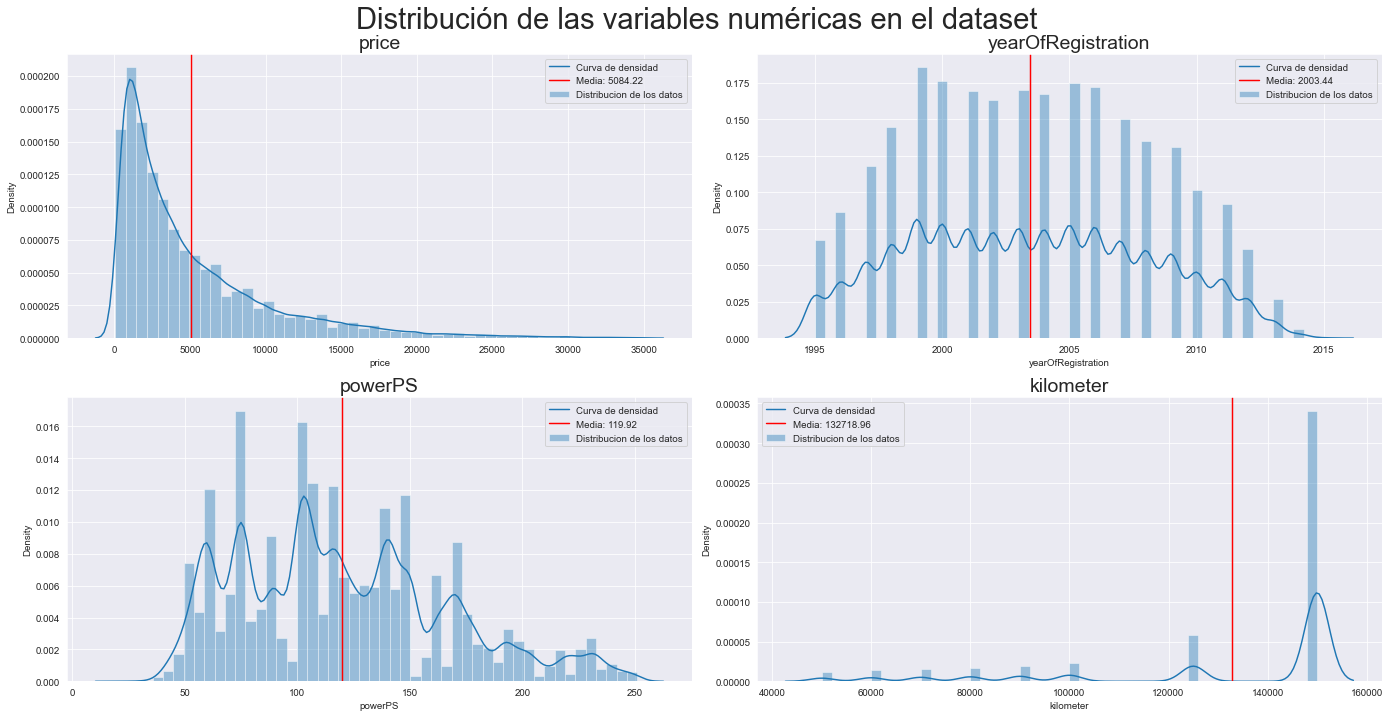

In [27]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna numérica y devolverá un histograma
for i in numerical_data:
    plt.subplot(a, b, c)
    plt.title(i)
    sns.distplot(df[i]).axvline(np.mean(df[i]), color='red')
    plt.legend(labels=['Curva de densidad',f'Media: {round(df[i].mean(),2)}', 'Distribucion de los datos'])
    c = c + 1

plt.suptitle('Distribución de las variables numéricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

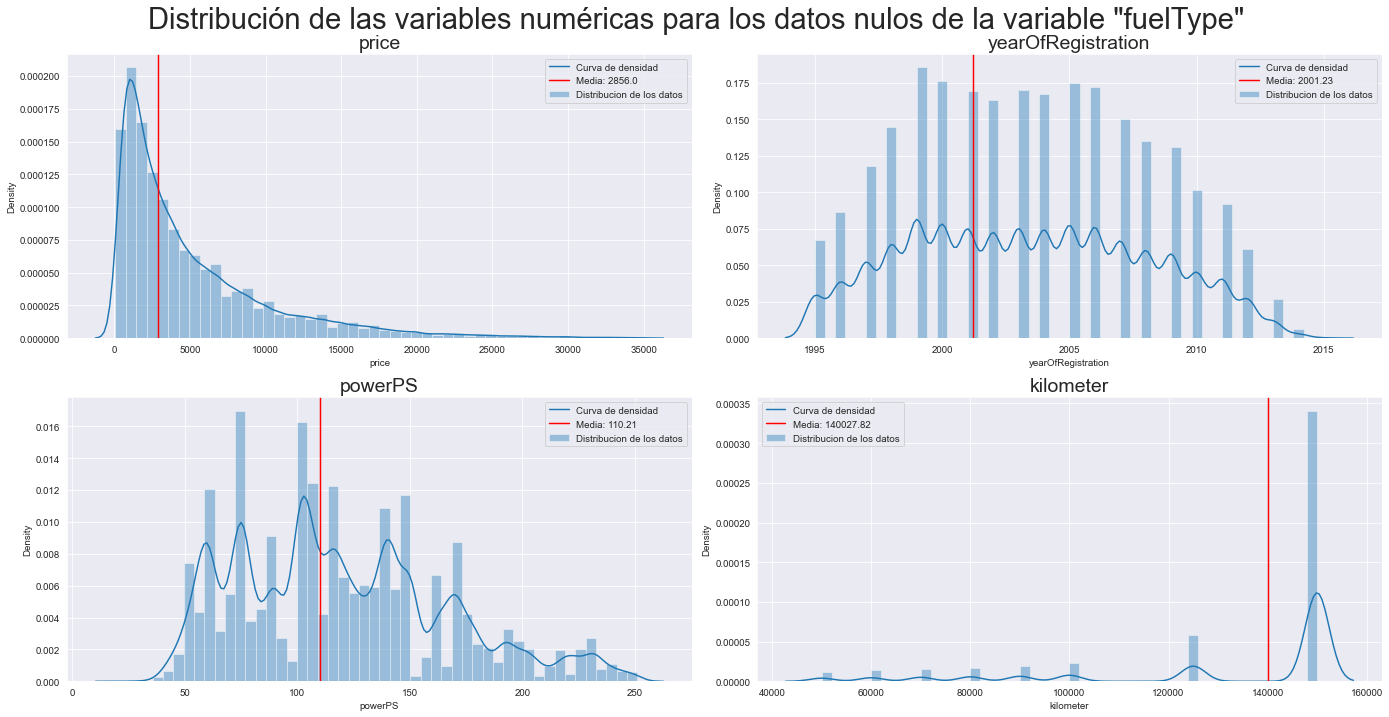

In [28]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna numérica y devolverá un histograma
for i in numerical_data:
    plt.subplot(a, b, c)
    plt.title(i)
    sns.distplot(df[i]).axvline(np.mean(df_nulos[i]), color='red')
    plt.legend(labels=['Curva de densidad',f'Media: {round(df_nulos[i].mean(),2)}', 'Distribucion de los datos'])
    c = c + 1

plt.suptitle('Distribución de las variables numéricas para los datos nulos de la variable "fuelType"', fontsize=30)
plt.tight_layout()
plt.show()

**Conclusiones**
- Se observa una cierta tendencia en los datos nulos de la variable 'fuelType' hacia autos más baratos, con más kilómetros, menos caballos y donde predominan los compactos (menor valor promedio que los sedán). Sin embargo, estas diferencias con la data completa no suponen un cambio en las distribuciones ni alteraciones fundamentales.
- No se observa que la pérdida de datos esté asociada exclusivamente a alguna categoría.

### Variable 'vehicleType'

In [29]:
# Separamos en un dataframe todas las observaciones que tienen 'notRepairedDamage' faltante
df_nulos = df[df.isna().any(1)]
df_nulos['vehicleType'].fillna('nulo', inplace=True)
df_nulos = df_nulos[df_nulos['vehicleType']=='nulo']
df_nulos['vehicleType'] = df_nulos['vehicleType'].astype('object')
df_nulos.shape

(5695, 10)

In [30]:
# Almacenamos a las variables discretas en la variable categorical_data
categorical_data = df[[#'vehicleType', 
                       'gearbox', 
                       'fuelType', 
                       'brand',
                       'postalZone',
                       'notRepairedDamage'
                      ]]


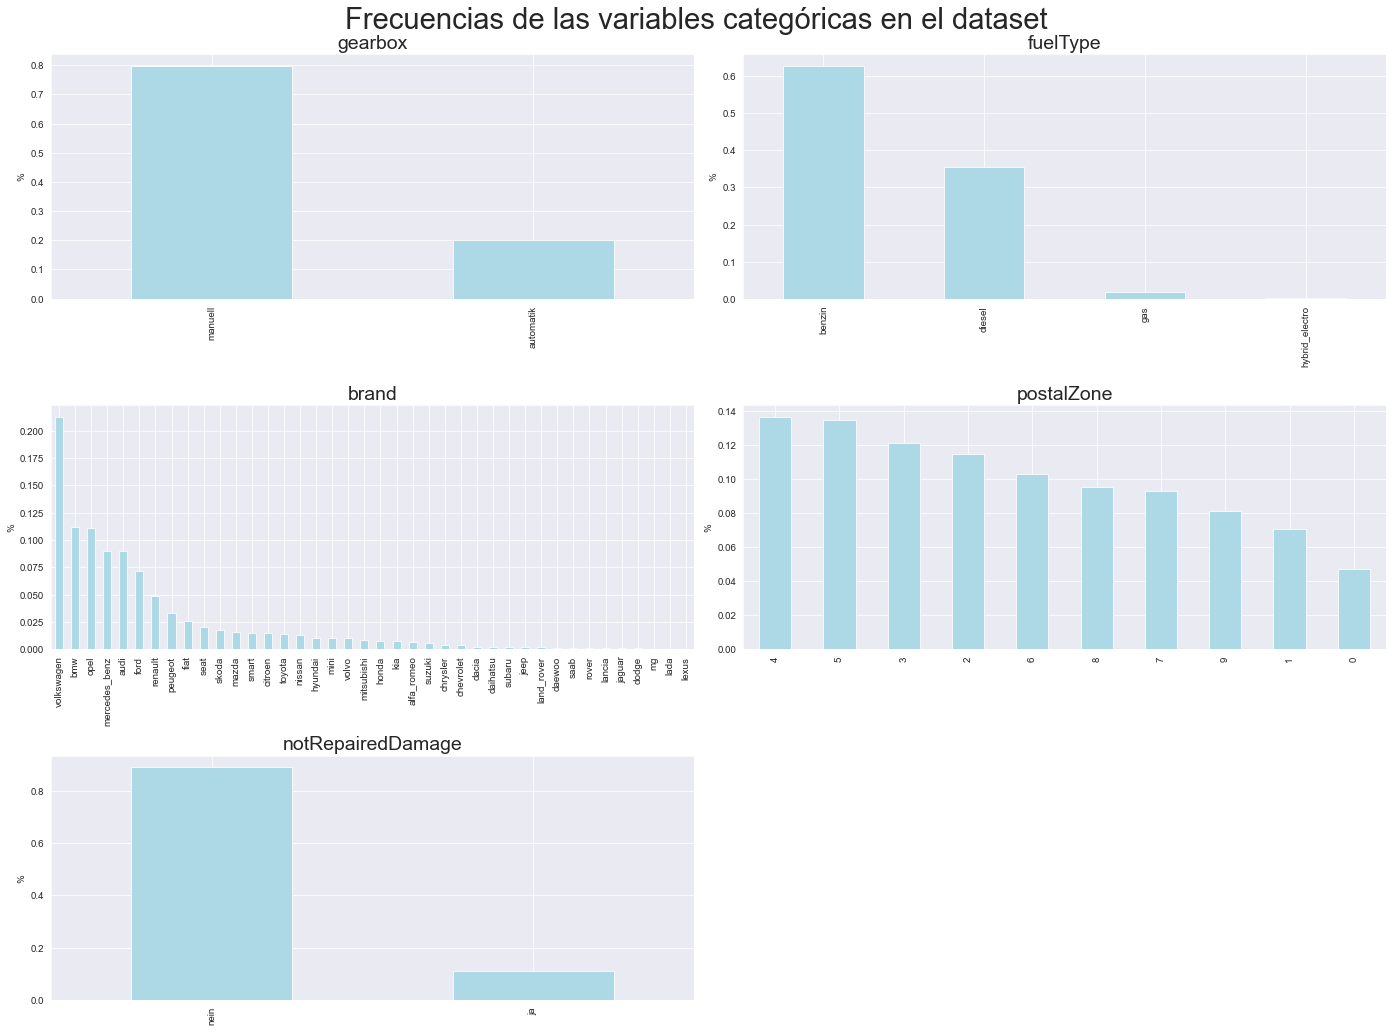

In [31]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

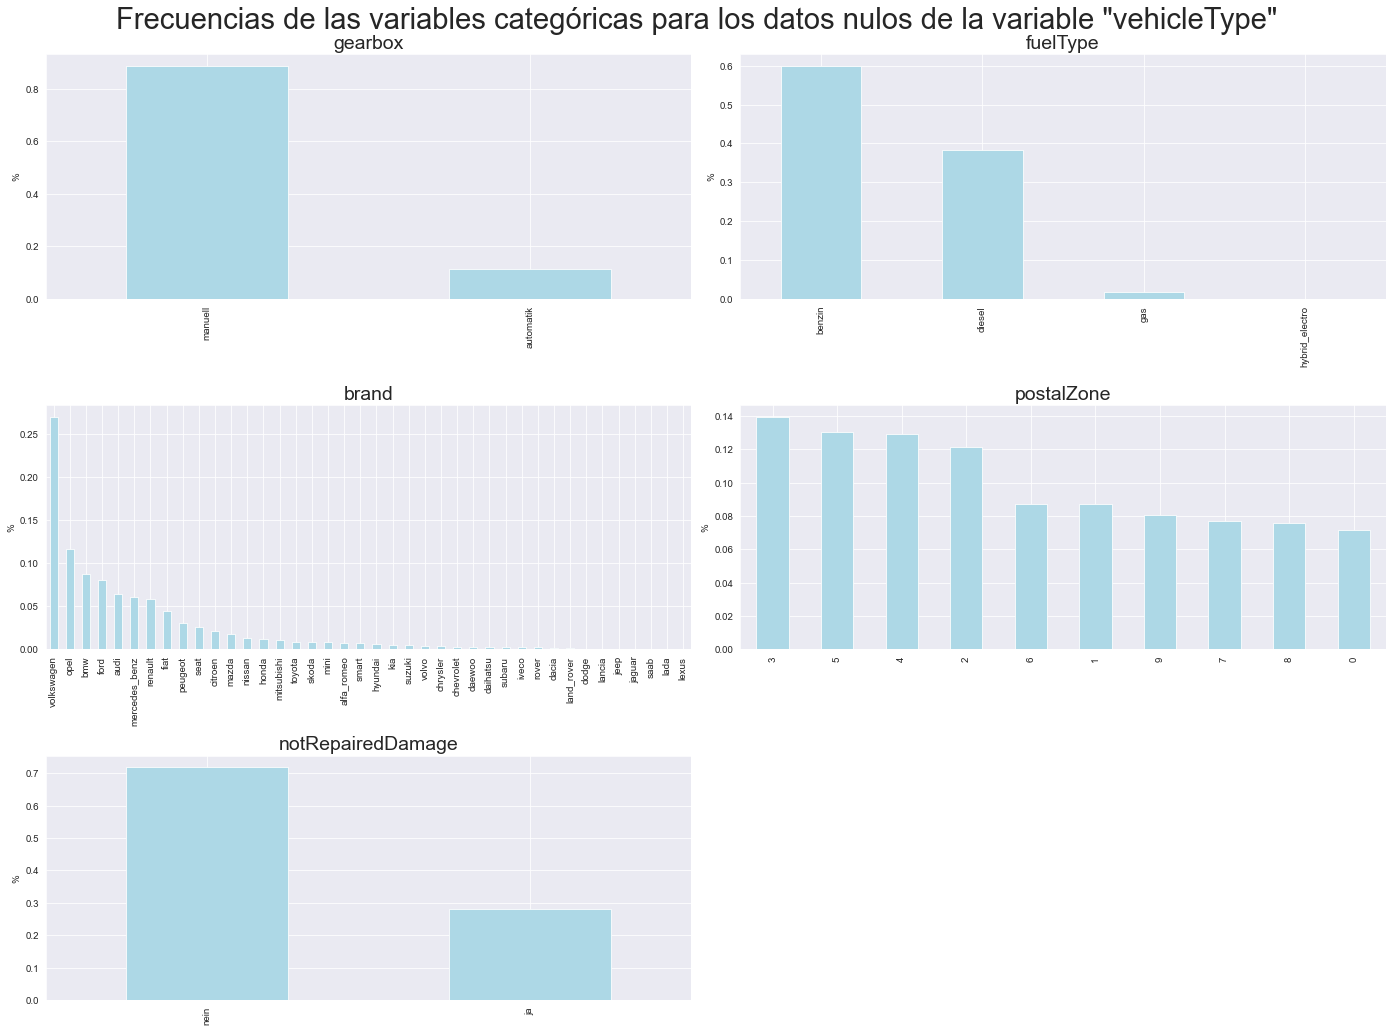

In [32]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df_nulos[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas para los datos nulos de la variable "vehicleType"', fontsize=30)
plt.tight_layout()
plt.show()

In [33]:
print('Datos estadísticos para los registros con valores perdidos en la variable "vehicleType"')
df_nulos.describe()

Datos estadísticos para los registros con valores perdidos en la variable "vehicleType"


,price,yearOfRegistration,powerPS,kilometer,postalZone
count,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000
mean,3085.451449,2002.073398,106.676910,138847.234416,4.313082
std,3779.241344,4.529134,40.953029,24402.797053,2.619560
min,60.000000,1995.000000,25.000000,50000.000000,0.000000
25%,600.000000,2000.000000,75.000000,150000.000000,2.000000
50%,1600.000000,2000.000000,101.000000,150000.000000,4.000000
75%,4100.000000,2005.000000,130.000000,150000.000000,6.000000
max,30000.000000,2015.000000,250.000000,150000.000000,9.000000


In [34]:
print('Datos estadísticos en el dataset sin modificaciones')
df.copy().describe().drop(columns='postalZone')

Datos estadísticos en el dataset sin modificaciones


,price,yearOfRegistration,powerPS,kilometer
count,249215.000000,249215.000000,249215.000000,249215.000000
mean,5084.224922,2003.435102,119.920587,132718.957527
std,5233.027125,4.628896,46.737053,29262.723940
min,55.000000,1995.000000,22.000000,50000.000000
25%,1430.000000,2000.000000,80.000000,125000.000000
50%,3200.000000,2003.000000,116.000000,150000.000000
75%,6950.000000,2007.000000,150.000000,150000.000000
max,34999.000000,2015.000000,251.000000,150000.000000


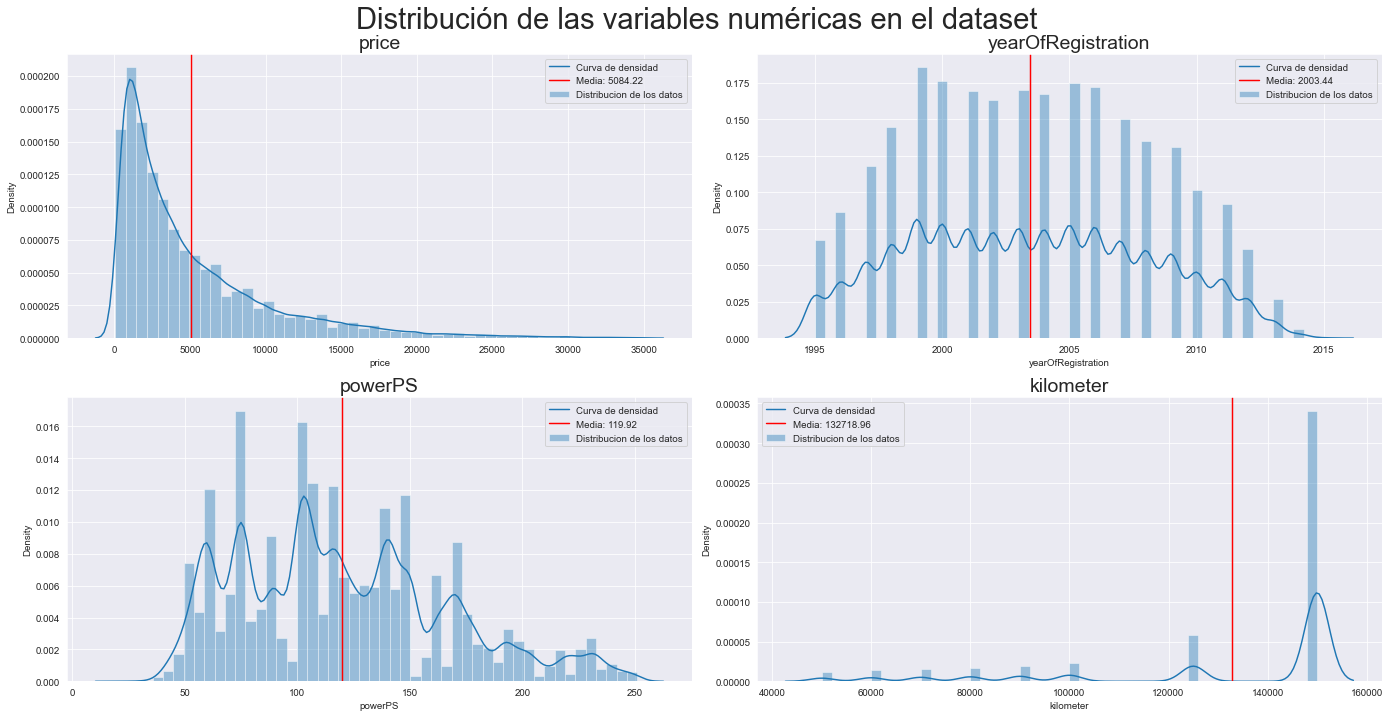

In [35]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna numérica y devolverá un histograma
for i in numerical_data:
    plt.subplot(a, b, c)
    plt.title(i)
    sns.distplot(df[i]).axvline(np.mean(df[i]), color='red')
    plt.legend(labels=['Curva de densidad',f'Media: {round(df[i].mean(),2)}', 'Distribucion de los datos'])
    c = c + 1

plt.suptitle('Distribución de las variables numéricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

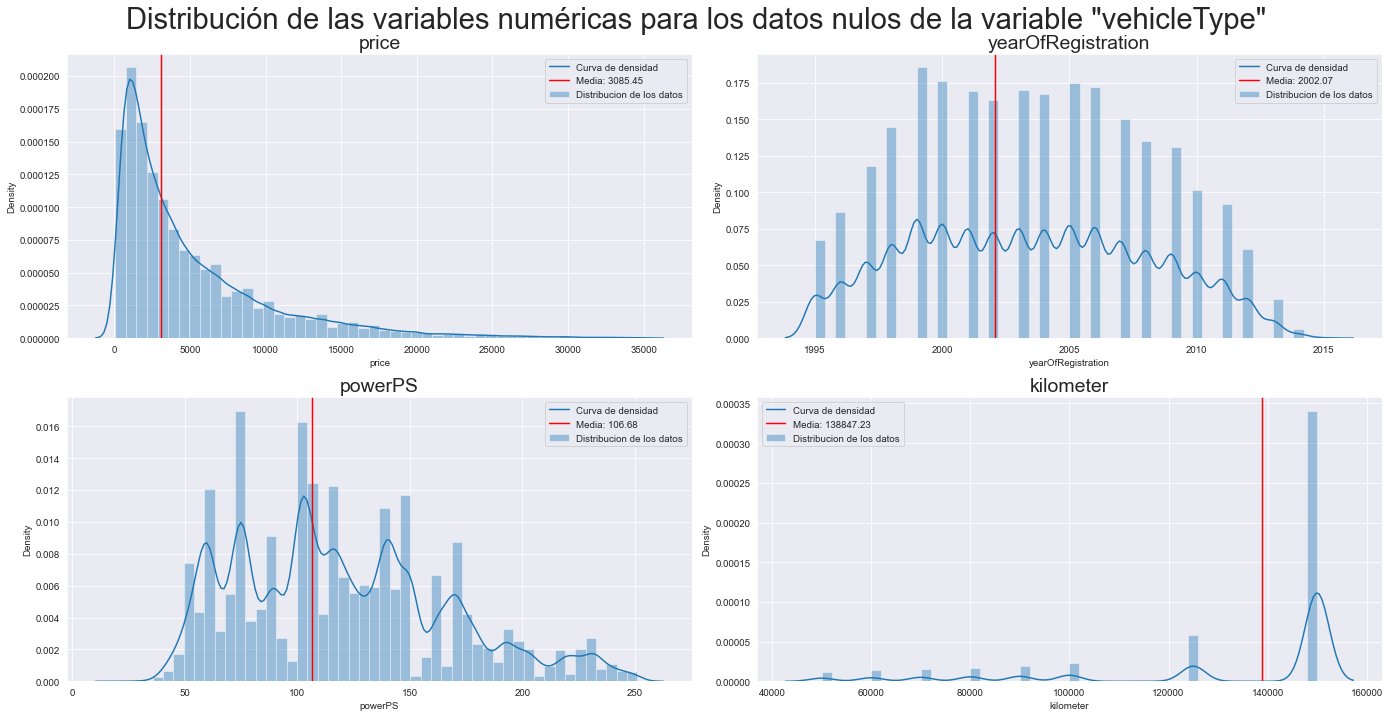

In [36]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna numérica y devolverá un histograma
for i in numerical_data:
    plt.subplot(a, b, c)
    plt.title(i)
    sns.distplot(df[i]).axvline(np.mean(df_nulos[i]), color='red')
    plt.legend(labels=['Curva de densidad',f'Media: {round(df_nulos[i].mean(),2)}', 'Distribucion de los datos'])
    c = c + 1

plt.suptitle('Distribución de las variables numéricas para los datos nulos de la variable "vehicleType"', fontsize=30)
plt.tight_layout()
plt.show()

**Conclusiones**
- Media de **precio** muy inferior para los registros con valores perdidos
- La mayoría de observaciones con datos perdidos se siguan en torno al año 2015

### Variable 'gearbox'

In [37]:
# Separamos en un dataframe todas las observaciones que tienen 'gearbox' faltante
df_nulos = df[df.isna().any(1)]
df_nulos['gearbox'].fillna('nulo', inplace=True)
df_nulos = df_nulos[df_nulos['gearbox']=='nulo']
df_nulos['gearbox'] = df_nulos['gearbox'].astype('object')
df_nulos.shape

(3963, 10)

In [38]:
# Almacenamos a las variables discretas en la variable categorical_data
categorical_data = df[['vehicleType', 
                       #'gearbox', 
                       'fuelType', 
                       'brand',
                       'postalZone',
                       'notRepairedDamage'
                      ]]


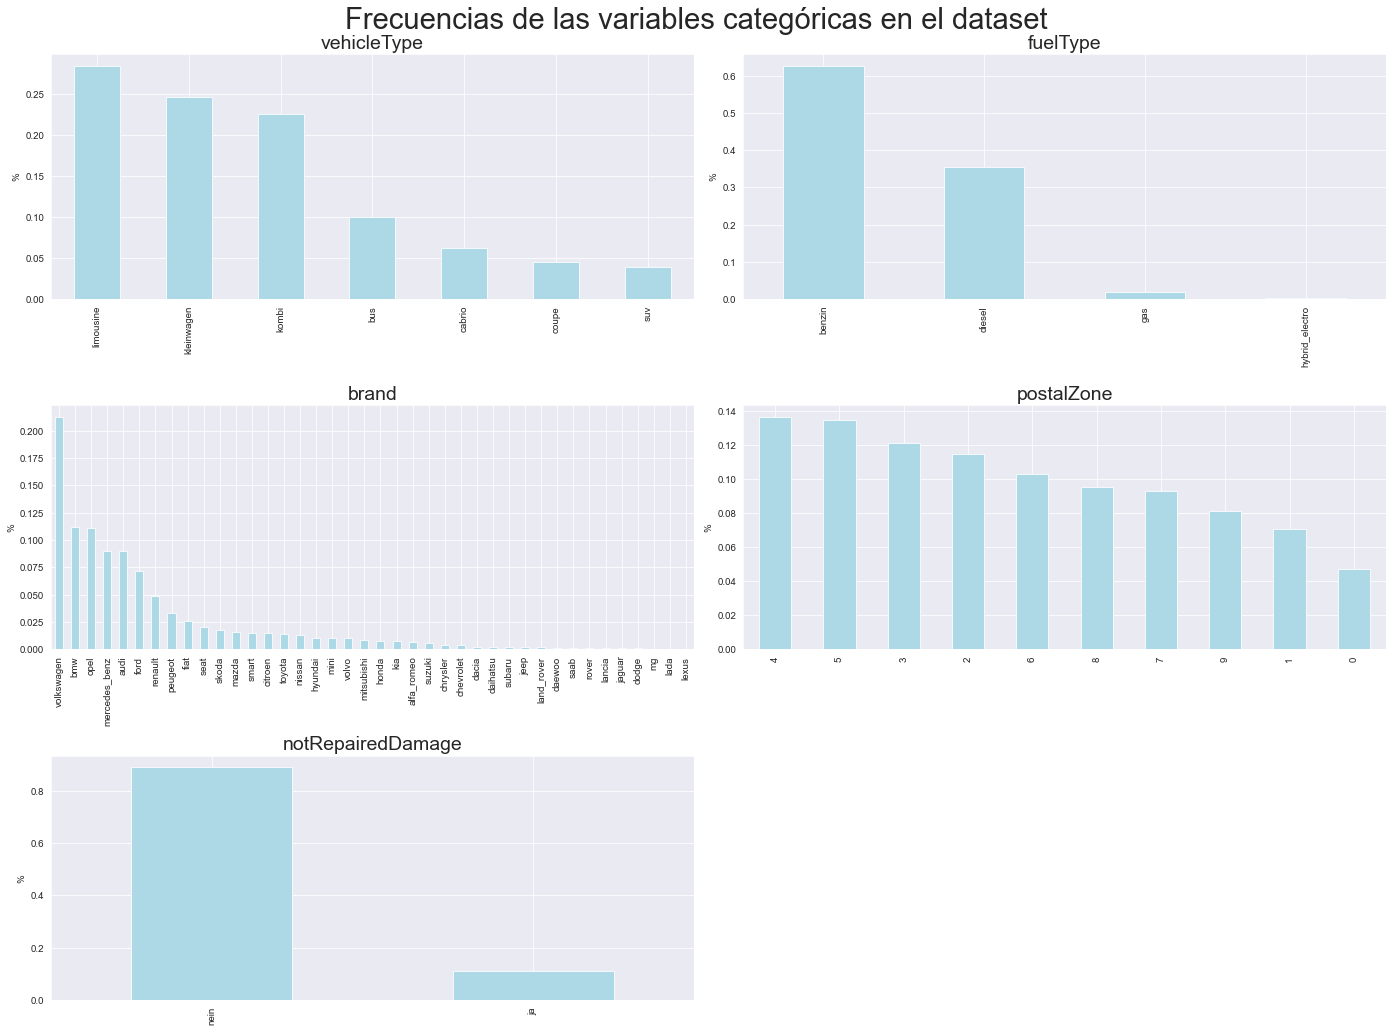

In [39]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

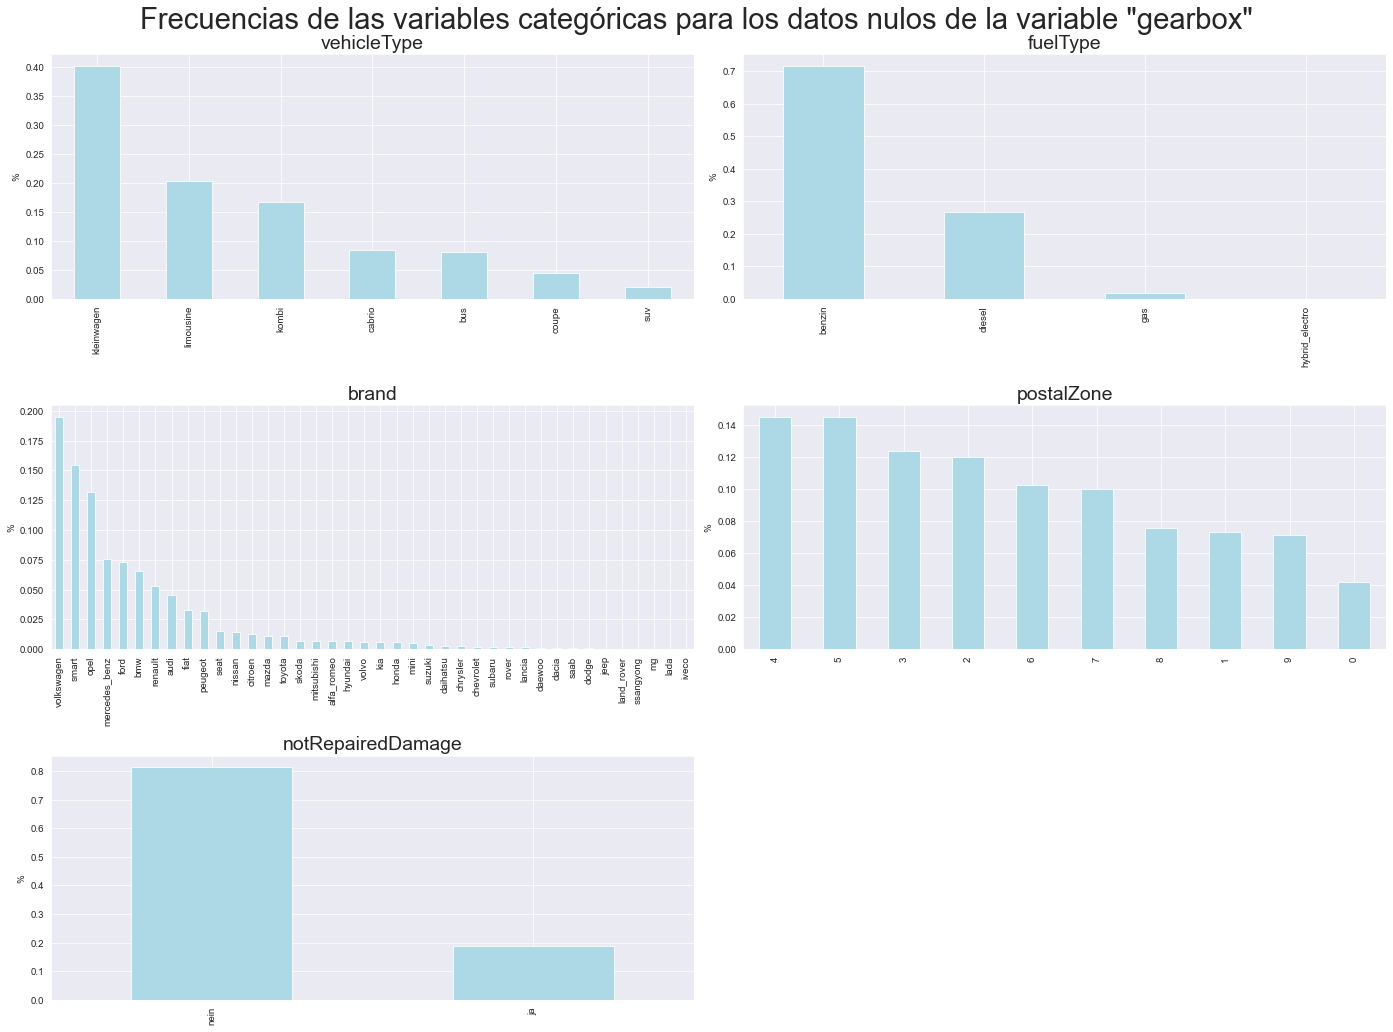

In [40]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df_nulos[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas para los datos nulos de la variable "gearbox"', fontsize=30)
plt.tight_layout()
plt.show()

In [41]:
print('Datos estadísticos para los registros con valores perdidos en la variable "gearbox"')
df_nulos.describe()

Datos estadísticos para los registros con valores perdidos en la variable "gearbox"


,price,yearOfRegistration,powerPS,kilometer,postalZone
count,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000
mean,3026.443099,2002.173101,99.136513,134335.099672,4.560686
std,3377.119775,4.284590,44.513380,27342.190901,2.467259
min,55.000000,1995.000000,29.000000,50000.000000,0.000000
25%,850.000000,1999.000000,61.000000,125000.000000,3.000000
50%,1800.000000,2001.000000,90.000000,150000.000000,4.000000
75%,3999.000000,2005.000000,125.000000,150000.000000,6.000000
max,30000.000000,2015.000000,250.000000,150000.000000,9.000000


In [42]:
print('Datos estadísticos en el dataset sin modificaciones')
df.copy().describe().drop(columns='postalZone')

Datos estadísticos en el dataset sin modificaciones


,price,yearOfRegistration,powerPS,kilometer
count,249215.000000,249215.000000,249215.000000,249215.000000
mean,5084.224922,2003.435102,119.920587,132718.957527
std,5233.027125,4.628896,46.737053,29262.723940
min,55.000000,1995.000000,22.000000,50000.000000
25%,1430.000000,2000.000000,80.000000,125000.000000
50%,3200.000000,2003.000000,116.000000,150000.000000
75%,6950.000000,2007.000000,150.000000,150000.000000
max,34999.000000,2015.000000,251.000000,150000.000000


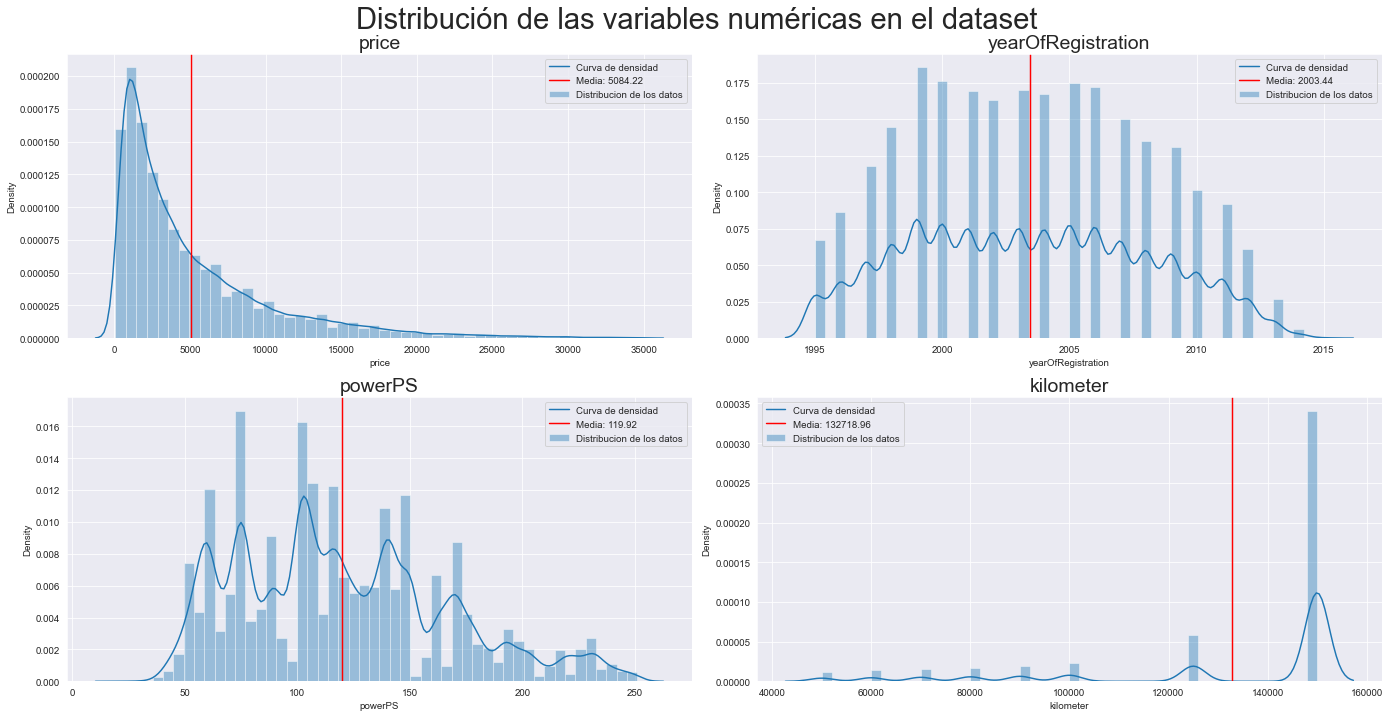

In [43]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna numérica y devolverá un histograma
for i in numerical_data:
    plt.subplot(a, b, c)
    plt.title(i)
    sns.distplot(df[i]).axvline(np.mean(df[i]), color='red')
    plt.legend(labels=['Curva de densidad',f'Media: {round(df[i].mean(),2)}', 'Distribucion de los datos'])
    c = c + 1

plt.suptitle('Distribución de las variables numéricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

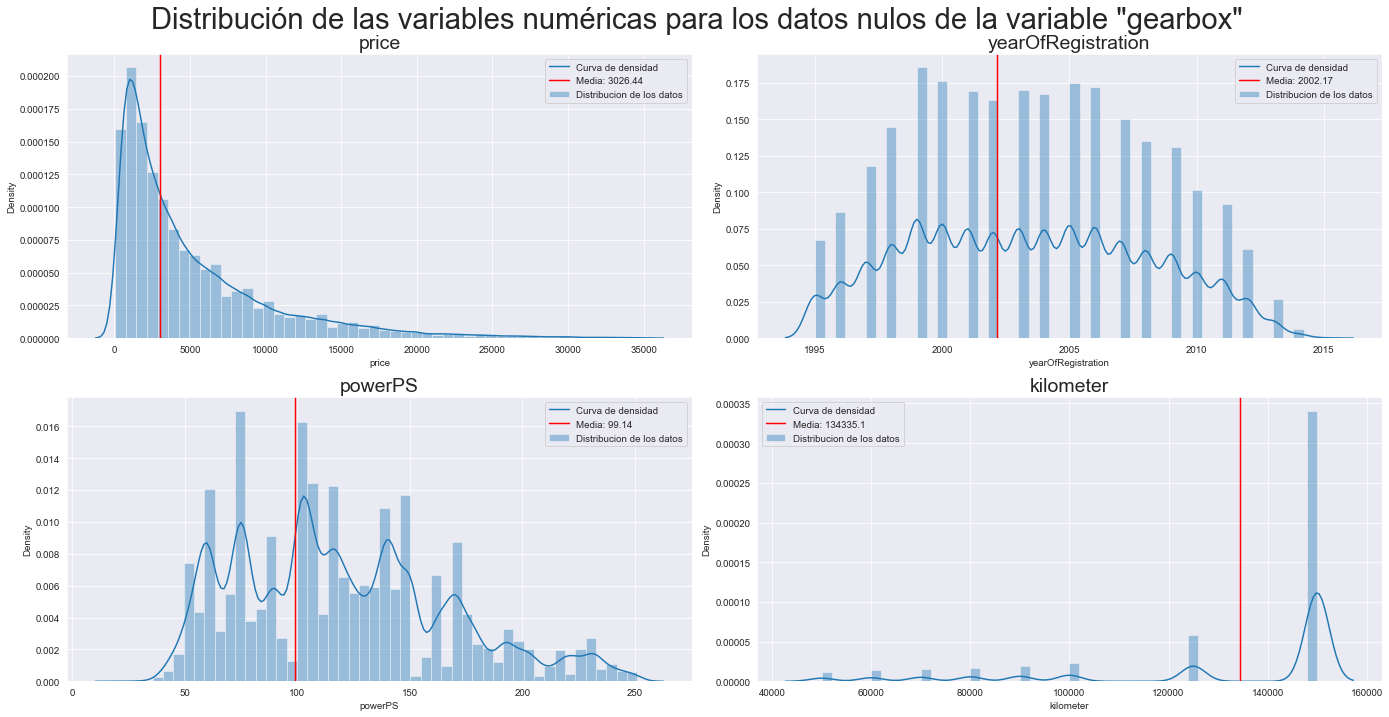

In [44]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna numérica y devolverá un histograma
for i in numerical_data:
    plt.subplot(a, b, c)
    plt.title(i)
    sns.distplot(df[i]).axvline(np.mean(df_nulos[i]), color='red')
    plt.legend(labels=['Curva de densidad',f'Media: {round(df_nulos[i].mean(),2)}', 'Distribucion de los datos'])
    c = c + 1

plt.suptitle('Distribución de las variables numéricas para los datos nulos de la variable "gearbox"', fontsize=30)
plt.tight_layout()
plt.show()

**Conclusiones**
- Media de **precio** muy inferior para los registros con valores perdidos
- Sin apenas diferencias en los **años** promedio.
- Media de **caballos** inferior a la general
- Media de **kilómetros** similar a la global
- En cuanto a principales **marcas**  con datos perdidos en la variable 'gearbox', el cambio más importante es la presencia de Smart que en la data global se situaba ligeramente por debajo de la media

### Conclusiones del análisis del tipo de datos nulos y pasos a seguir
- Como se ha podido comprobar la los datos perdidos no se asocian a ninguna categoría en particular exceptuando la elevada presencia de vehículos de la marca Smart para los datos nulos de la variable 'gearbox' respecto al dataset global. 
- Se observa una tendencia común en los datos perdidos de todas las variables analizadas según la cual estos pertenecrían a vehículos de un menor precio promedio y con menores prestaciones.
- Pensamos que nos encontramos ante lo que se conoce como **datos perdidos al azar (MAR)**, esto quiere decir que los datos faltantes están relacionados con otras variables observadas, pero no directamente con el valor faltante.
- Se va a proceder a la imputación de los datos perdidos de las variables.

## Imputación de los datos perdidos
- En este caso vamos a llevar a cabo la imputación mediante KNN Imputer.
- KNN Imputer es un algoritmo de imputación de datos que se utiliza para rellenar valores faltantes en un conjunto de datos. La idea básica detrás del KNN Imputer es usar el enfoque K-Nearest Neighbors (KNN) para encontrar y promediar los valores de los vecinos más cercanos al dato con valor faltante.
- Al pertenecer nuestros datos perdidos variables categóricas debemos tomar algunas precauciones
    - Preparacion de los datos para la imputación: binarización de las variables categóricas
    - Trabajamos solo con 1 vecino (n_neighbors = 1). Al estar imputando variables categoricas donde solo tenemos dos clases (0 y 1), utilizar más de 1 vecino nos entregaría medias inconsistentes.
- Es importante tener en cuenta que el KNN Imputer puede ser computacionalmente intensivo en grandes conjuntos de datos motivo por el cual dejaremos comentadas las lineas de la imputación y exportaremos el resultado a fin de no tener que repetir el proceso 

### Preparación de los datos para la imputación
La utilización del algoritmo KNN que vamos a utilizar para la imputación requiere que todas las variables categóricas sean binarizadas

In [45]:
# Creamos una copia del dataframe con el que procederemos a la imputación
df_imp = df.copy()
df_imp['postalZone'] = df_imp['postalZone'].astype('object')

In [46]:
# Binarizamos con el método One-Hot Encoding (despues tendremos que eliminar variables redundantes para evitar colinealidad)
# El motivo de usar OHE es que necesitamos todas las columnas para imputar
df_imp_dummies = pd.get_dummies(df_imp, dummy_na=True) #drop_first = True

In [47]:
%%time
# Almacenamos los nombres de las variables categóricas que contienen datos nulos
col_cat_nuls = ['notRepairedDamage', 'vehicleType', 'gearbox', 'fuelType']

# Transformamos en valor perdido todos los registros de las columnas binarizadas cuya columna de origen contenia valores perdidos
for col in col_cat_nuls:
    df_preproc_imp = aux.imputer_preprocessing(df_imp_dummies, col)

CPU times: total: 5min 12s
Wall time: 5min 17s


In [48]:
# Eliminamos las columnas que se crearon al binarizar con dummy_na=True
df_preproc_imp.drop(columns= df_preproc_imp.filter(regex = '_nan').columns, inplace=True)

In [49]:
# Comprobamos como se agregaron tantos datos nulos a cada variable binaria como habia originalmente
aux.datos_nulos_analisis(df_preproc_imp)

,variable,cantidades,porcentajes
62,notRepairedDamage_nein,33104.0,0.132833
61,notRepairedDamage_ja,33104.0,0.132833
14,fuelType_diesel,10602.0,0.042542
16,fuelType_hybrid_electro,10602.0,0.042542
15,fuelType_gas,10602.0,0.042542
...,...,...,...
37,brand_lada,0.0,0.000000
38,brand_lancia,0.0,0.000000
39,brand_land_rover,0.0,0.000000
40,brand_lexus,0.0,0.000000


In [50]:
aux.datos_nulos_analisis(df)

,variable,cantidades,porcentajes
8,notRepairedDamage,33104.0,0.132833
6,fuelType,10602.0,0.042542
1,vehicleType,5695.0,0.022852
3,gearbox,3963.0,0.015902
0,price,0.0,0.000000
2,yearOfRegistration,0.0,0.000000
4,powerPS,0.0,0.000000
5,kilometer,0.0,0.000000
7,brand,0.0,0.000000
9,postalZone,0.0,0.000000


### Imputación de los datos perdidos
- Vamos a dejar comentadas las líneas del proceso de imputación debido a la demora del proceso.

In [51]:
# Separamos el vector objetivo de la matriz de atributos independientes
X_mat = df_preproc_imp.drop(columns='price')
y_vec = df_preproc_imp['price']

In [52]:
#%%time
## Creamos un objeto de la clase KNN Imputer
#imputer = KNNImputer(n_neighbors = 1)
#
## Ajustamos y transformamos la data de entrenamiento
#X_mat_imp = imputer.fit_transform(X_mat)

In [53]:
## Conversión de los conjuntso de entrenamiento y prueba a dataframe
#columnas_originales = X_mat.columns
#
#X_mat_imp = pd.DataFrame(X_mat_imp, columns=columnas_originales)

In [54]:
## Almacenamos los resultados de la imputación para ahorrarnos el tiempo de volver a entrenar (más de una hora)
#X_mat_imp.to_csv('X_mat_imp.csv', index = False)

In [55]:
# Leemos los datos imputados
X_mat_imp = pd.read_csv('X_mat_imp.csv')

In [56]:
df_imp_final = pd.concat([y_vec, X_mat_imp], axis=1)

In [57]:
# Verificamos que las dimensiones del dataframe resultante de la imputación son las mismas que el dataframe con el que la iniciamos
assert df_imp_final.shape == df_preproc_imp.shape

### Resultados de la imputación

- Para comprobar los efectos de la imputación frente al dataframe original debemos desbinarizar la data imputada
- Comprobamos si hubo cambios en las frecuencias de las variables imputadas respecto a la data de entrada
- Comprobamos si hubo cambios en las la relación entre las variables imputadas y el vector objetivo respecto a la data de entrada
- Al no haberse alterado las variables numéricas no es necesario comprobar cambios en su distribución

In [58]:
# Identificar las columnas codificadas
columnas_codificadas_vehicleType = [col for col in df_imp_final.columns if 'vehicleType_' in col]
columnas_codificadas_gearbox = [col for col in df_imp_final.columns if 'gearbox_' in col]
columnas_codificadas_fuelType = [col for col in df_imp_final.columns if 'fuelType_' in col]
columnas_codificadas_brand = [col for col in df_imp_final.columns if 'brand_' in col]
columnas_codificadas_postalZone = [col for col in df_imp_final.columns if 'postalZone_' in col]
columnas_codificadas_notRepairedDamage = [col for col in df_imp_final.columns if 'notRepairedDamage_' in col]

# Crear un nuevo DataFrame con las columnas codificadas
df_decodificado_vehicleType = df_imp_final[columnas_codificadas_vehicleType]
df_decodificado_gearbox = df_imp_final[columnas_codificadas_gearbox]
df_decodificado_fuelType = df_imp_final[columnas_codificadas_fuelType]
df_decodificado_brand = df_imp_final[columnas_codificadas_brand]
df_decodificado_postalZone = df_imp_final[columnas_codificadas_postalZone]
df_decodificado_notRepairedDamage = df_imp_final[columnas_codificadas_notRepairedDamage]

df_imp_decod = pd.DataFrame()

# Obtener la categoría original para cada fila
df_imp_decod['vehicleType'] = df_decodificado_vehicleType.idxmax(axis=1).apply(lambda x: x.split('_')[1])
df_imp_decod['gearbox'] = df_decodificado_gearbox.idxmax(axis=1).apply(lambda x: x.split('_')[1])
df_imp_decod['fuelType'] = df_decodificado_fuelType.idxmax(axis=1).apply(lambda x: x.split('_')[1])
df_imp_decod['brand'] = df_decodificado_brand.idxmax(axis=1).apply(lambda x: x.split('_')[1])
df_imp_decod['notRepairedDamage'] = df_decodificado_notRepairedDamage.idxmax(axis=1).apply(lambda x: x.split('_')[1])
df_imp_decod['postalZone'] = df_decodificado_postalZone.idxmax(axis=1).apply(lambda x: x.split('_')[1])

In [59]:
df_imp_decod = pd.concat([df_imp[['price', 'yearOfRegistration', 'powerPS', 'kilometer']], df_imp_decod], axis=1)

In [60]:
df_imp_decod.shape

(249215, 10)

In [61]:
# Almacenamos a las variables discretas en la variable categorical_data
categorical_data = df[['vehicleType', 
                       'gearbox', 
                       'fuelType', 
                       'brand',
                       'notRepairedDamage'
                      ]]


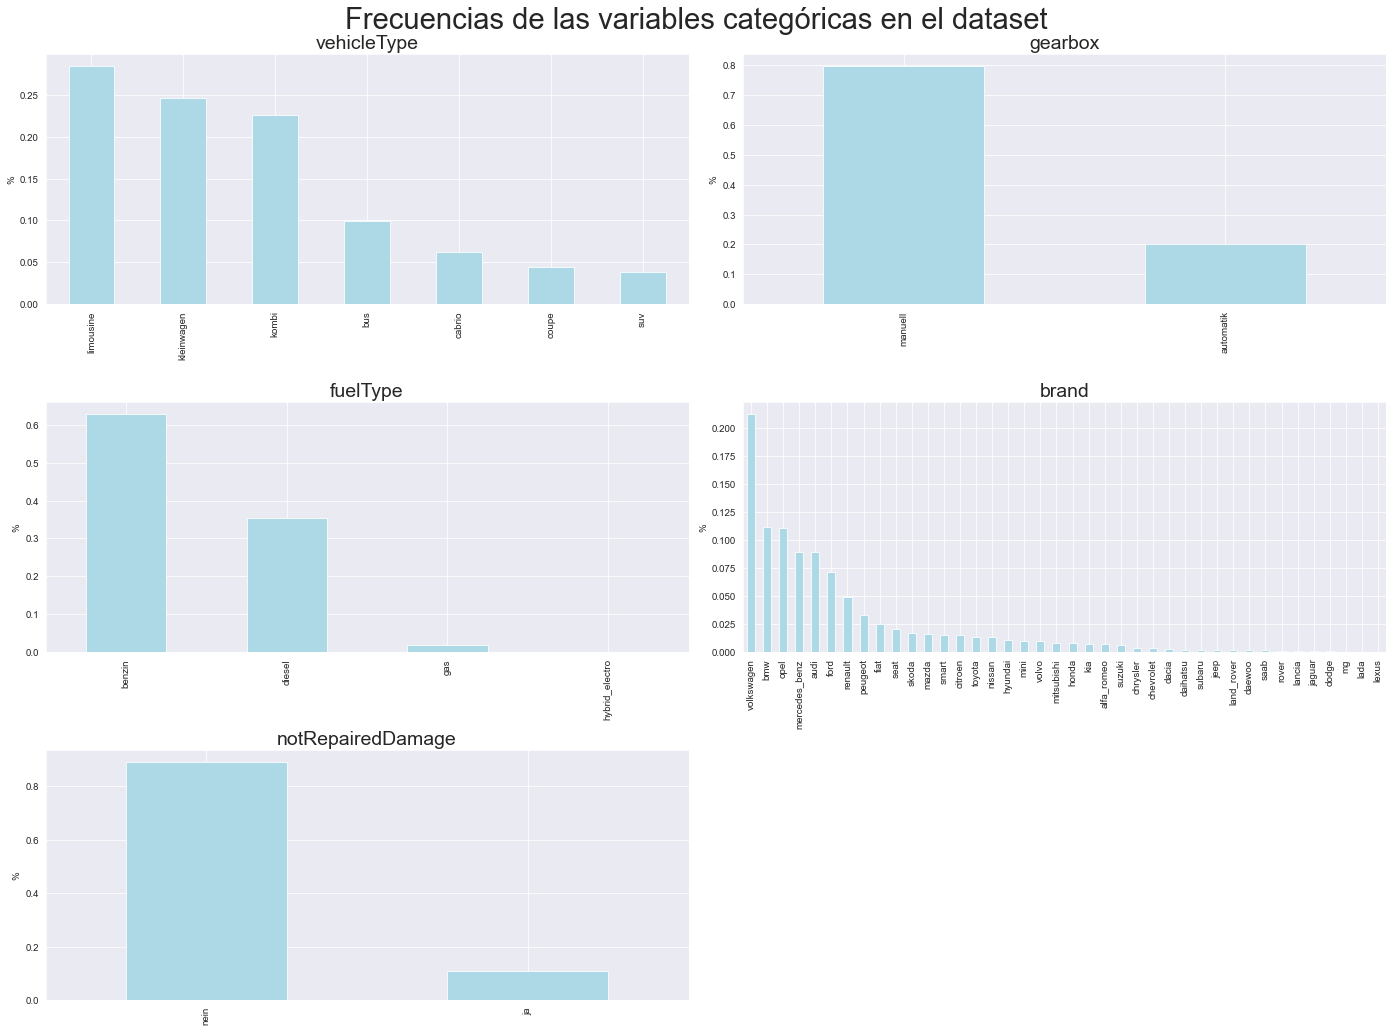

In [62]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas en el dataset', fontsize=30)
plt.tight_layout()
plt.show()

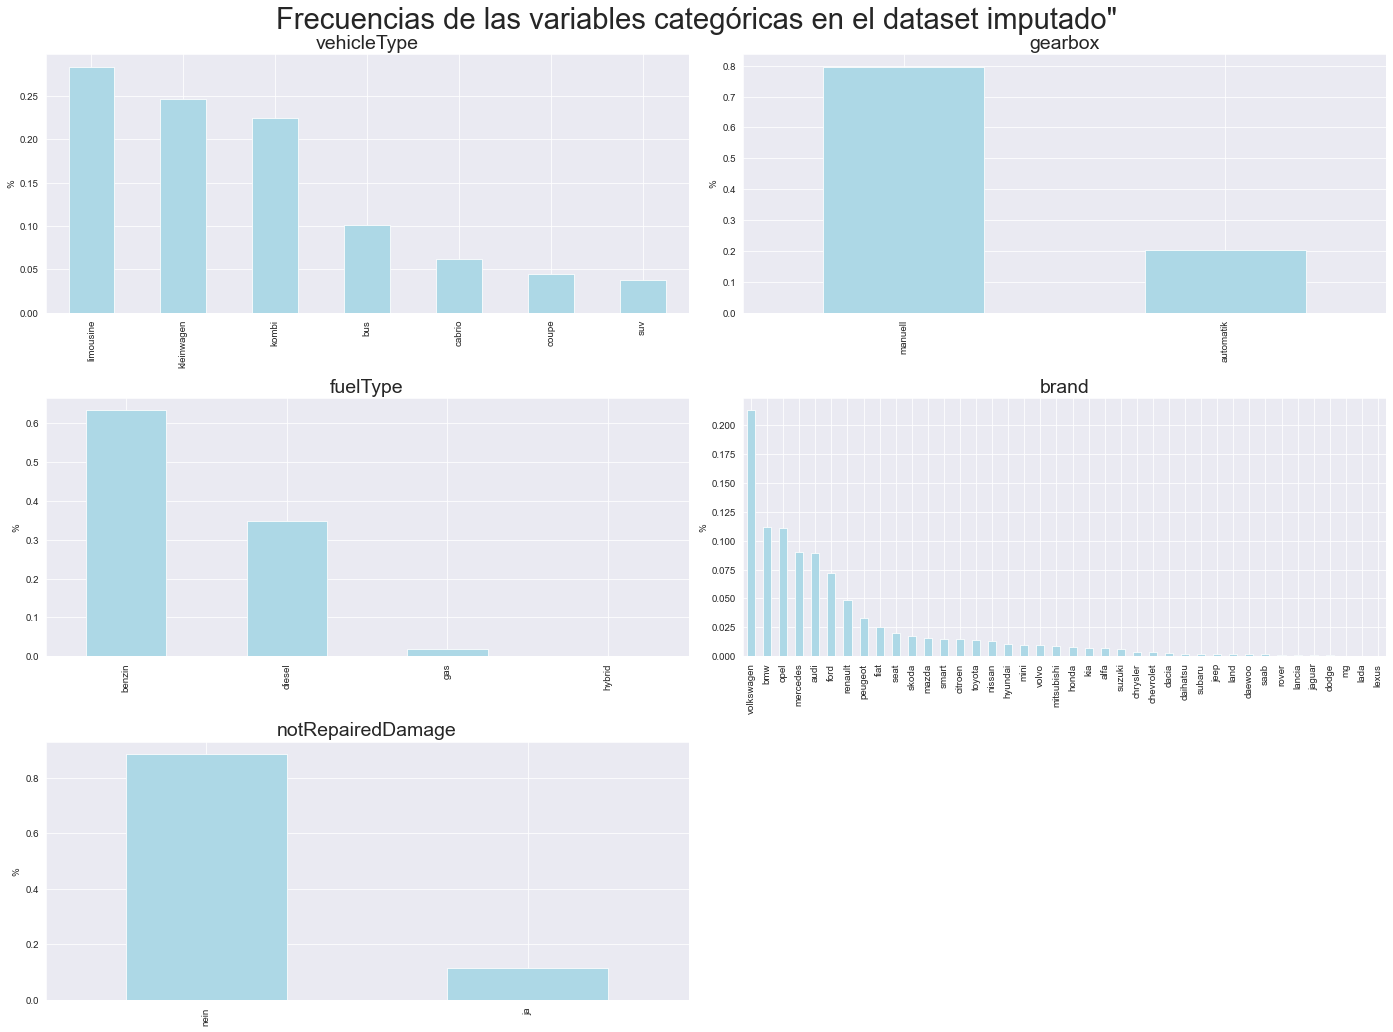

In [63]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    df_imp_decod[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Frecuencias de las variables categóricas en el dataset imputado"', fontsize=30)
plt.tight_layout()
plt.show()

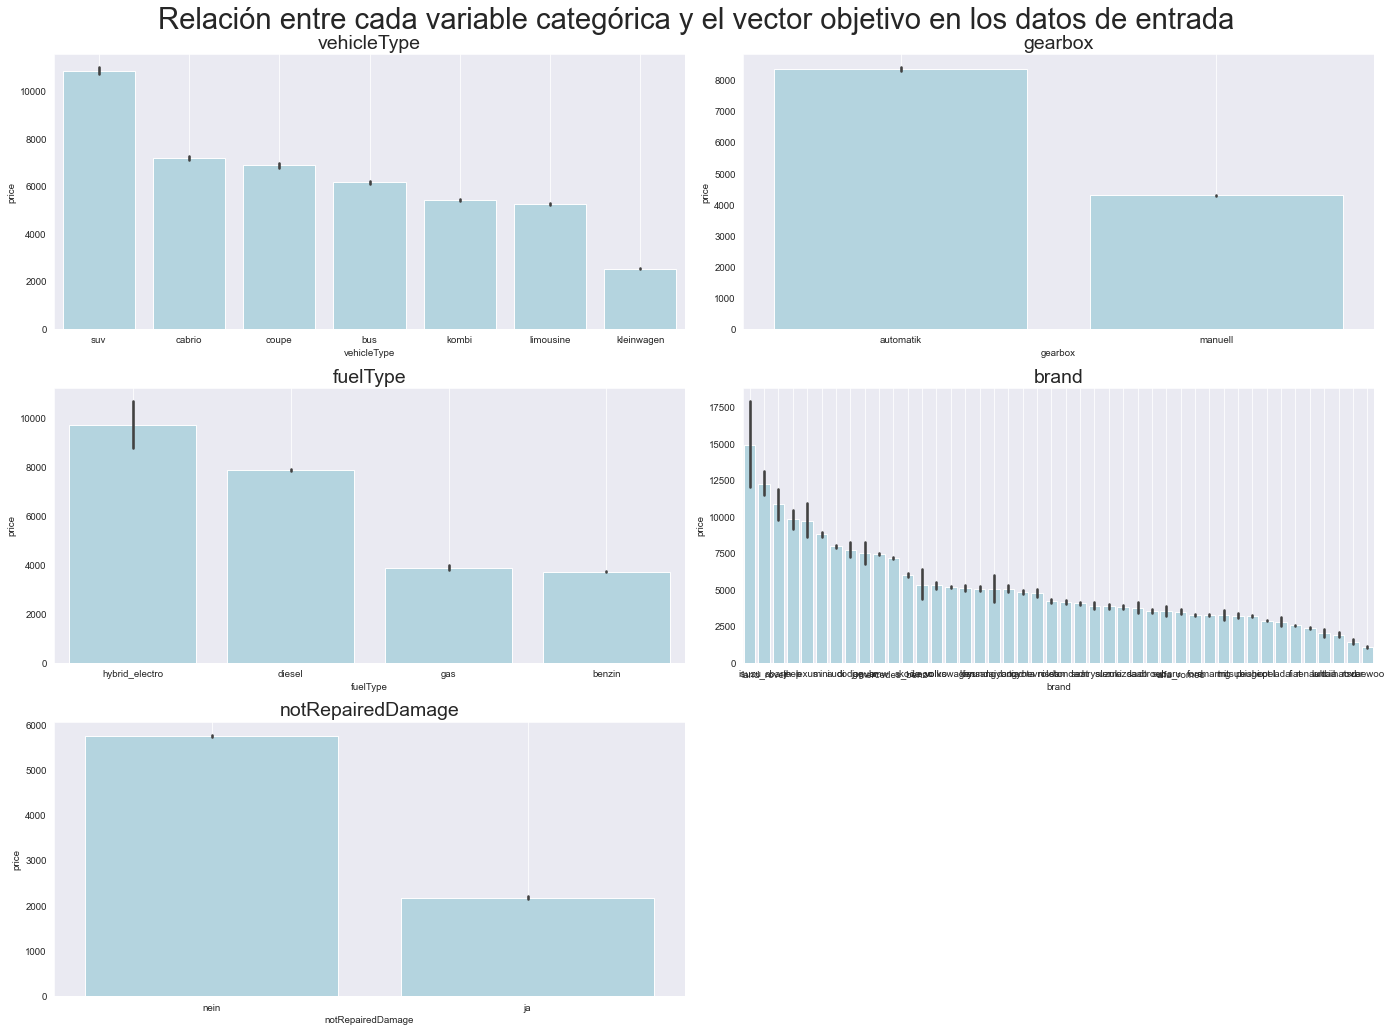

In [64]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    aux.barplot_bivariado(df, 'price', i, orient='vertical')
    #df[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Relación entre cada variable categórica y el vector objetivo en los datos de entrada', fontsize=30)
plt.tight_layout()
plt.show()

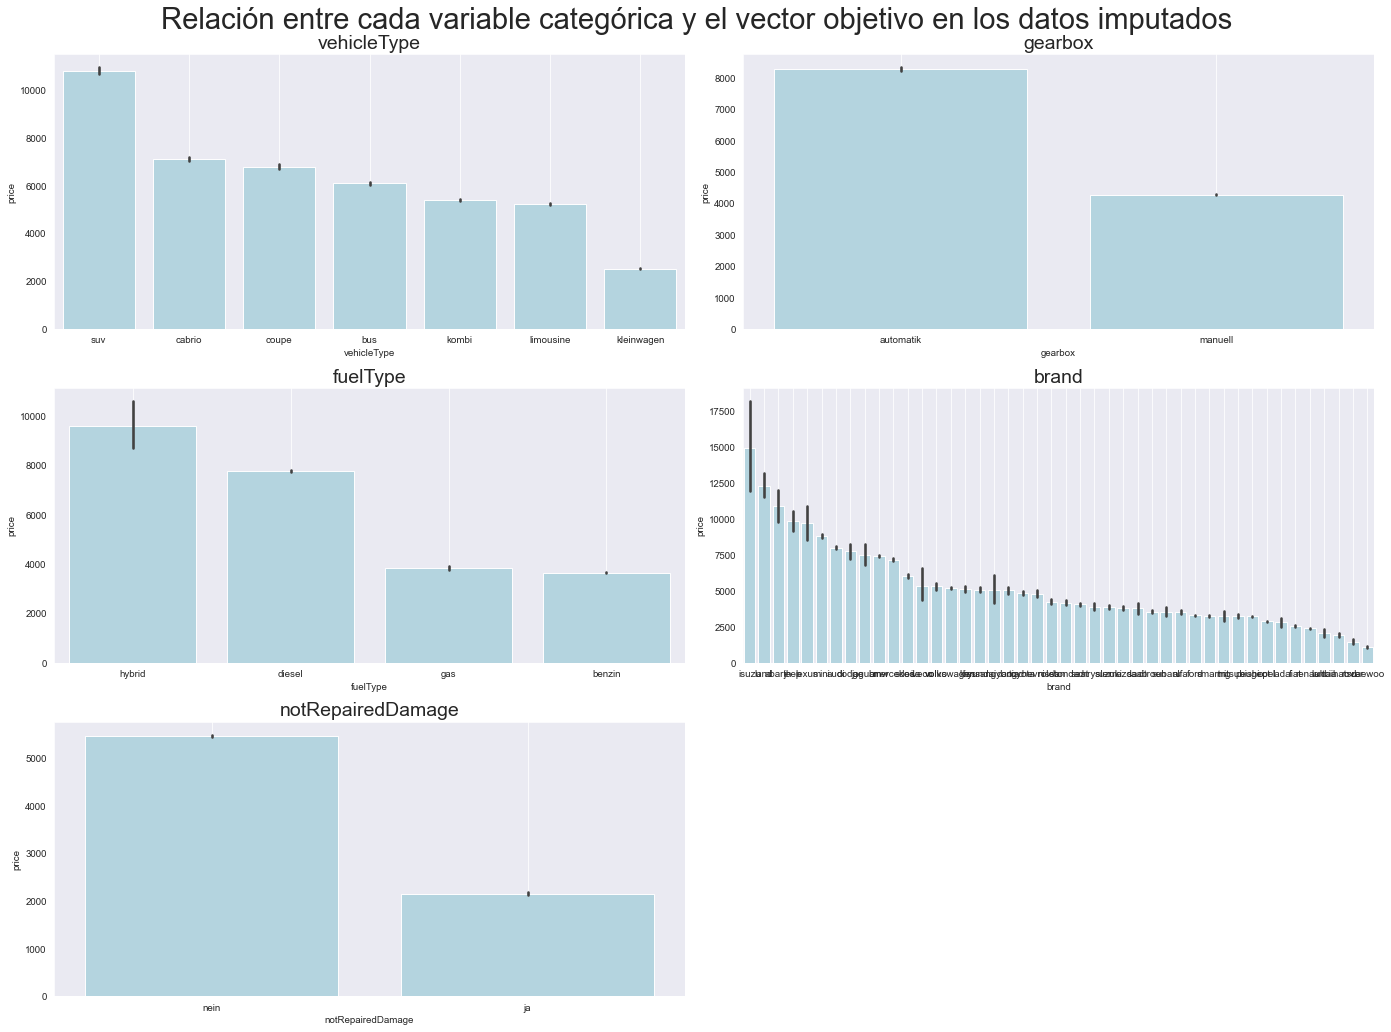

In [65]:
# Establecemos el número de filas y columnas para nuestros subplots
a = 3 # número de filas
b = 2 # número de columnas
c = 1 # inicialización del conteo de plots

# Establecemos el tamaño de nuestra figura de subplots
fig = plt.subplots(figsize=(20, 15)) 

# Construimos un bucle for que iterará por cada columna categórica y devolverá un gráfico de barras
for i in categorical_data:
    plt.subplot(a, b, c) 
    plt.title(i)
    plt.ylabel('%')
    aux.barplot_bivariado(df_imp_decod, 'price', i, orient='vertical')
    #df[i].value_counts(normalize=True).head(40).plot(kind='bar', title=i, rot=90, linewidth = 0.8, color='lightblue')
    c = c + 1

plt.suptitle('Relación entre cada variable categórica y el vector objetivo en los datos imputados', fontsize=30)
plt.tight_layout()
plt.show()

**Conclusiones**
- Sin cambios de peso en las frecuencias de las variables categóricas después de la imputación

### De one hot encoding a binary encoding
- Una vez finalizada la imputación y su análisis eliminamos una columna binaria para cada variable categórica con fin de evitar colinealidad en el modelamiento predictivo

In [66]:
drop_columns = ['vehicleType_bus', 'gearbox_automatik', 'fuelType_hybrid_electro', 'brand_abarth', 'postalZone_0.0', 'notRepairedDamage_ja']

In [67]:
before_drop = df_imp_final.shape[1]
df_imp_final.drop(columns = drop_columns, inplace=True)
after_drop = df_imp_final.shape[1]
print(f'Columnas eliminadas: {before_drop - after_drop}')

Columnas eliminadas: 6


## Eliminación de la variable notRepairedDamage
- Una vez realizada la imputación de los datos faltantes para esta variable que era la que más datos de este tipo contenía vamos a eliminar aquellos que pertenecen a la clase ja (sí). 
- El motivo es que el tipo de daños sin reparar puede ser enormemente variable y supondría una gran pérdida de precisión en el modelo. 
- Por ejemplo, la diferencia de la penalización en el precio que debería suponer un espejo retrovisor roto no debería ser la misma que la de una caja de cambios con problemas, sin embargo, el modelo estaría penalizando por igual.

In [68]:
df_imp_final['notRepairedDamage_nein'].value_counts()

1.0    220738
0.0     28477
Name: notRepairedDamage_nein, dtype: int64

In [69]:
# Eliminar filas con "notRepairedDamage" == ja o NaN
before_drop = df_imp_final.shape[0]
df_imp_final = df_imp_final[(df_imp_final['notRepairedDamage_nein'] == 1.0)]
after_drop = df_imp_final.shape[0]
print(f'Registros eliminados: {before_drop - after_drop}')

Registros eliminados: 28477


In [70]:
df_imp_final.shape

(220738, 67)

In [71]:
# Eliminamos la columna "notRepairedDamage"
before_drop = df_imp_final.shape[1]
df_imp_final.drop(columns='notRepairedDamage_nein', inplace=True)
after_drop = df_imp_final.shape[1]
print(f'Columnas eliminadas: {before_drop - after_drop}')

Columnas eliminadas: 1


In [72]:
df_imp_final.shape

(220738, 66)

In [73]:
# Transformamos los float en integer
df_imp_final = df_imp_final.astype('int64')

## Exportación de los datos

In [74]:
# Dataset perteneciente a los datos faltantes imputados
df_imp_final.to_csv('df_imp.csv', index = False)